# Tabular Data - Context Engineering

## 왜 테이블 데이터는 특별한 처리가 필요한가?

테이블은 **구조화된 정보로써, 정보 밀도가 높은 형식**으로 인간이 읽고 이해하기는 쉽지만, 뜯어보면 AI 가 이해하기 어려운 형태입니다.  

일반적인 Text Data 와는 다른 특성이 있습니다:

1. **컨텍스트 부족**: 테이블만 단순히 보면 의미 파악이 어려움 **(헤더, 단위, 전후 맥락, 통계치, 도메인 지식 등이 Tabular 해석에 필요)**
2. **임베딩 비효율**: 테이블을 아무 생각없이 Chunking / Indexing 하면 의미없이 잘리게 되어, 유사도가 매우 낮은 결과물이 생성됌(=> 따라서 테이블은 Indexing 전 '추가 처리' 가 필요함)
3. **검색 실패**: "2023년 매출은?" 같은 질문에 테이블 원본만으로는 답하기 어려움 -> Table 에 대한 조회, 병합, 피벗테이블 생성 등 추가적인 처리 프로세스가 필요하다는 점
  
### 그럼 우리는 어떻게 이러한 Tabular Data 를 적절하게 처리하고 또 그것을 잘 활용하게 할 수 있을까요?

## 1. Parse 단계에서 `Tabular Data` 를 식별

In [1]:
# ----------------------------------------------------------------------------
# OpenAI / OpenRouter 모델 초기화 헬퍼
# ----------------------------------------------------------------------------
import os
from typing import Literal

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv()


def _resolve_api_context() -> tuple[str, str]:
    """선택된 API 키와 베이스 URL 정보를 반환합니다."""
    api_key = os.getenv("OPENROUTER_API_KEY")
    if not api_key:
        raise RuntimeError("OPENROUTER_API_KEY가 필요합니다.")

    base_url = os.getenv("OPENROUTER_API_BASE") or "https://openrouter.ai/api/v1"

    return (api_key, base_url)


def create_openrouter_llm(
    model: str = "openai/gpt-4.1-mini",
    temperature: float = 0.3,
    max_tokens: int | None = None,
    **kwargs: object,
) -> ChatOpenAI:
    """OpenAI 호환 LLM 생성 헬퍼.

    Args:
        model: 모델 이름. OpenRouter에서는 provider/model 형식 사용 가능
               (예: openai/gpt-4o, anthropic/claude-3-sonnet, google/gemini-pro)
        temperature: 생성 온도 (0.0-2.0)
        max_tokens: 최대 생성 토큰 수

    Returns:
        ChatOpenAI: 설정된 LLM 인스턴스
    """
    api_key, base_url = _resolve_api_context()

    openai_kwargs: dict = {
        "model": model,
        "api_key": api_key,
        "temperature": temperature,
        "max_retries": 3,
        "timeout": 60,
        **kwargs,
    }
    if max_tokens is not None:
        openai_kwargs["max_tokens"] = max_tokens
    if base_url:
        openai_kwargs["base_url"] = base_url
    return ChatOpenAI(**openai_kwargs)


def create_embedding_model(
    model: str = "openai/text-embedding-3-small",
    **kwargs,
) -> OpenAIEmbeddings:
    """OpenAI 호환 임베딩 모델 생성.

    Args:
        model: 임베딩 모델 이름. OpenRouter에서는 provider/model 형식 사용 가능
               (예: openai/text-embedding-3-small, openai/text-embedding-3-large)
        **kwargs: 추가 파라미터 (encoding_format 등은 model_kwargs로 전달됨)

    Returns:
        OpenAIEmbeddings: 설정된 임베딩 모델 인스턴스
    """
    api_key, base_url = _resolve_api_context()

    # 전달받은 kwargs에서 model_kwargs로 전달할 파라미터 분리
    # encoding_format, extra_headers 등은 model_kwargs로 전달
    model_kwargs: dict = {}
    embedding_kwargs: dict = {
        "model": model,
        "api_key": api_key,
        "show_progress_bar": True,
        "skip_empty": True,
    }

    # 전달받은 kwargs 처리
    for key, value in kwargs.items():
        # OpenRouter API 특정 파라미터는 model_kwargs로 전달
        if key in ("encoding_format"):
            model_kwargs[key] = value
        else:
            # 나머지는 OpenAIEmbeddings에 직접 전달
            embedding_kwargs[key] = value

    if base_url:
        embedding_kwargs["base_url"] = base_url

    # model_kwargs가 있으면 전달
    if model_kwargs:
        embedding_kwargs["model_kwargs"] = model_kwargs

    return OpenAIEmbeddings(**embedding_kwargs)


def create_embedding_model_direct(
    model: str = "qwen/qwen3-embedding-0.6b",
    encoding_format: Literal["float", "base64"] = "float",
    input_text: str | list[str] = "",
    **kwargs,
) -> list[float] | list[list[float]]:
    """OpenAI SDK를 직접 사용하여 임베딩 생성 (encoding_format 지원).

    LangChain의 OpenAIEmbeddings가 encoding_format을 지원하지 않을 때 사용.

    Args:
        model: 임베딩 모델 이름
        encoding_format: 인코딩 형식 ("float")
        input_text: 임베딩할 텍스트 (문자열 또는 문자열 리스트)
        **kwargs: 추가 파라미터

    Returns:
        임베딩 벡터 리스트 (단일 텍스트) 또는 리스트의 리스트 (여러 텍스트)
    """
    from openai import OpenAI

    api_key, base_url = _resolve_api_context()

    client = OpenAI(
        base_url=base_url,
        api_key=api_key,
    )

    # input_text가 비어있으면 kwargs에서 가져오기
    if not input_text:
        input_text = kwargs.get("input", "")

    response = client.embeddings.create(
        model=model,
        input=input_text,
        encoding_format=encoding_format,
    )

    # 단일 텍스트인 경우 첫 번째 임베딩 반환
    if isinstance(input_text, str):
        return response.data[0].embedding
    else:
        # 여러 텍스트인 경우 모든 임베딩 반환
        return [item.embedding for item in response.data]


def get_available_model_types() -> dict[str, list[str]]:
    """OpenRouter에서 사용 가능한 모델 유형을 반환합니다.

    Returns:
        dict[str, list[str]]: 모델 유형별 모델 목록
    """
    return {
        "chat": [
            "openai/gpt-4.1",
            "openai/gpt-4.1-mini",
            "openai/gpt-5",
            "openai/gpt-5-mini",
            "anthropic/claude-sonnet-4.5",
            "anthropic/claude-haiku-4.5",
            "google/gemini-2.5-flash-preview-09-2025",
            "google/gemini-pro-2.5",
            "x-ai/grok-4-fast",
            "moonshotai/kimi-k2-thinking",
            "liquid/lfm-2.2-6b",
            "z-ai/glm-4.6",
        ],
        "embedding": [
            "openai/text-embedding-3-small",
            "openai/text-embedding-3-large",
            "google/gemini-embedding-001",
            "qwen/qwen3-embedding-0.6b",
            "qwen/qwen3-embedding-4b",
            "qwen/qwen3-embedding-8b",
        ],
    }


embeddings = create_embedding_model()
llm = create_openrouter_llm()

In [31]:
# Upstage Parser를 통해 테이블 데이터 추출 및 CSV 저장
import json
import time
from pathlib import Path
from pprint import pprint

import pandas as pd
from dotenv import load_dotenv

load_dotenv()

upstage_api_key = os.getenv("UPSTAGE_API_KEY")
PDF_FILE_PATH = Path("./stock/20251110_market_823764000.pdf")


# ============================================================================
# 테이블 추출 함수들
# ============================================================================


def extract_tables_from_elements(elements: list[dict]) -> dict[int, list[dict]]:
    """elements에서 테이블 카테고리만 추출하고 ID별로 그룹화

    Args:
        elements: Upstage API 응답의 elements 배열

    Returns:
        테이블 ID를 키로 하는 딕셔너리, 값은 해당 ID의 element 리스트 (페이지 순 정렬)
    """
    table_groups = {}

    for elem in elements:
        if elem.get("category") == "table":
            table_id = elem.get("id", 0)
            if table_id not in table_groups:
                table_groups[table_id] = []
            table_groups[table_id].append(elem)

    # 각 그룹을 페이지 순으로 정렬
    for table_id in table_groups:
        table_groups[table_id].sort(key=lambda x: x.get("page", 0))

    return table_groups


def parse_table_content(content: dict | str) -> pd.DataFrame | None:
    """테이블 content를 pandas DataFrame으로 변환

    Args:
        content: element의 content 필드 (dict 또는 str)

    Returns:
        파싱된 DataFrame 또는 실패 시 None
    """
    try:
        # Case 1: content가 dict이고 html 키를 포함하는 경우
        if isinstance(content, dict):
            if "html" in content and content["html"]:
                html_str = content["html"]
                dfs = pd.read_html(html_str)
                if dfs:
                    return dfs[0]
            elif "markdown" in content and content["markdown"]:
                # markdown 필드 우선 시도
                markdown_str = content["markdown"]
                return parse_markdown_table(markdown_str)
            elif "text" in content and content["text"]:
                # text 필드가 HTML인지 확인
                text_str = content["text"]
                if "<table" in text_str.lower():
                    dfs = pd.read_html(text_str)
                    if dfs:
                        return dfs[0]
                # Markdown 테이블 파싱 시도
                return parse_markdown_table(text_str)

        # Case 2: content가 문자열인 경우
        elif isinstance(content, str):
            # HTML 태그 포함 여부 확인
            if "<table" in content.lower():
                dfs = pd.read_html(content)
                if dfs:
                    return dfs[0]
            # Markdown 테이블 파싱 시도
            return parse_markdown_table(content)

        # Case 3: 파싱 불가능한 경우
        print("  파싱 불가능한 content 형식:")
        print(f"   타입: {type(content)}")
        if isinstance(content, dict):
            print(f"   키: {list(content.keys())}")
        return None

    except Exception as e:
        print(f"  테이블 파싱 실패: {e}")
        print(f"   Content 타입: {type(content)}")
        if isinstance(content, dict):
            print(f"   Content 샘플: {json.dumps(content, ensure_ascii=False)[:200]}")
        return None


def parse_markdown_table(text: str) -> pd.DataFrame | None:
    """Markdown 형식의 테이블을 DataFrame으로 변환

    Args:
        text: Markdown 테이블 텍스트

    Returns:
        파싱된 DataFrame 또는 실패 시 None
    """
    try:
        lines = [line.strip() for line in text.strip().split("\n") if line.strip()]

        if not lines or "|" not in lines[0]:
            return None

        # 구분선 찾기 (컬럼 개수 기준으로 사용)
        separator_idx = None
        num_columns = None

        for i, line in enumerate(lines):
            if line.startswith("|---") or line.startswith("---") or all(c in "|-: " for c in line):
                separator_idx = i
                # 구분선의 컬럼 개수를 기준으로 사용
                num_columns = len([c for c in line.split("|") if c.strip()])
                break

        if separator_idx is None or num_columns is None or num_columns == 0:
            # 구분선이 없으면 기본 파싱 시도
            separator_idx = 0
            num_columns = len([c for c in lines[0].split("|")[1:-1]])  # 앞뒤 빈 문자열 제외

        # 헤더 추출 (구분선 이전 행들)
        header_lines = lines[:separator_idx] if separator_idx > 0 else [lines[0]]

        # 헤더를 구분선 기준 컬럼 개수에 맞춰 파싱
        columns = []
        if header_lines:
            header_parts = header_lines[0].split("|")[1:-1]  # 앞뒤 빈 문자열 제거
            # 구분선 컬럼 개수에 맞춰 조정
            for i in range(num_columns):
                if i < len(header_parts):
                    col_name = header_parts[i].strip()
                    columns.append(col_name if col_name else f"Col_{i + 1}")
                else:
                    columns.append(f"Col_{i + 1}")
        else:
            columns = [f"Col_{i + 1}" for i in range(num_columns)]

        # 데이터 행 추출 (구분선 이후)
        data_start_idx = separator_idx + 1 if separator_idx > 0 else 1
        data_rows = []

        for line in lines[data_start_idx:]:
            # 구분선은 스킵
            if line.startswith("|---") or line.startswith("---") or all(c in "|-: " for c in line):
                continue

            # 모든 셀 파싱 (빈 셀 포함)
            parts = line.split("|")[1:-1]  # 앞뒤 빈 문자열 제거
            row = [cell.strip() for cell in parts]

            # 컬럼 개수에 맞춰 조정 (패딩 또는 자르기)
            if len(row) < num_columns:
                row.extend([""] * (num_columns - len(row)))  # 부족하면 빈 문자열로 채움
            elif len(row) > num_columns:
                row = row[:num_columns]  # 많으면 자름

            # 완전히 빈 행은 제외
            if any(cell for cell in row):
                data_rows.append(row)

        if not data_rows:
            return None

        # DataFrame 생성
        df = pd.DataFrame(data_rows, columns=columns)

        # 빈 문자열을 NaN으로 변환
        df = df.replace("", pd.NA)

        return df

    except Exception as e:
        print(f"   ⚠️  Markdown 테이블 파싱 실패: {e}")
        import traceback

        traceback.print_exc()
        return None


def merge_table_dataframes(table_elements: list[dict]) -> pd.DataFrame | None:
    """동일 테이블 ID의 여러 페이지 데이터를 병합

    Args:
        table_elements: 동일 ID를 가진 테이블 element 리스트 (페이지 순 정렬됨)

    Returns:
        병합된 DataFrame 또는 실패 시 None
    """
    if not table_elements:
        return None

    dfs = []
    for elem in table_elements:
        content = elem.get("content", {})
        df = parse_table_content(content)
        if df is not None:
            dfs.append(df)

    if not dfs:
        return None

    # 단일 DataFrame인 경우
    if len(dfs) == 1:
        return dfs[0]

    # 여러 DataFrame 병합
    try:
        # 컬럼이 동일한지 확인
        first_cols = list(dfs[0].columns)
        if all(list(df.columns) == first_cols for df in dfs):
            # 컬럼이 동일하면 단순 concat
            merged_df = pd.concat(dfs, ignore_index=True)
        else:
            # 컬럼이 다르면 외부 조인
            merged_df = pd.concat(dfs, ignore_index=True, sort=False)

        return merged_df

    except Exception as e:
        print(f" 테이블 병합 실패: {e}")
        # 병합 실패 시 첫 번째 DataFrame 반환
        return dfs[0]


def save_table_to_csv(
    df: pd.DataFrame,
    pdf_name: str,
    table_id: int,
    page_range: tuple[int, int],
    output_dir: Path = Path("./chunks"),
) -> Path:
    """DataFrame을 CSV 파일로 저장

    Args:
        df: 저장할 DataFrame
        pdf_name: PDF 파일명 (확장자 제외)
        table_id: 테이블 ID
        page_range: 페이지 범위 (시작, 끝)
        output_dir: 출력 디렉토리

    Returns:
        저장된 파일 경로
    """
    # 출력 디렉토리 생성
    output_dir.mkdir(parents=True, exist_ok=True)

    # 파일명 생성
    min_page, max_page = page_range
    if min_page == max_page:
        filename = f"{pdf_name}_table_{table_id}_p{min_page}.csv"
    else:
        filename = f"{pdf_name}_table_{table_id}_p{min_page}-{max_page}.csv"

    output_path = output_dir / filename

    # CSV 저장 (UTF-8 BOM으로 Excel 호환성 확보)
    df.to_csv(output_path, index=False, encoding="utf-8-sig")

    return output_path


def process_tables_from_upstage_result(
    result: dict,
    pdf_path: Path,
    output_dir: Path = Path("./chunks"),
) -> list[Path]:
    """Upstage API 결과에서 테이블 추출 및 CSV 저장

    Args:
        result: Upstage Document Parse API 응답
        pdf_path: 원본 PDF 파일 경로
        output_dir: CSV 저장 디렉토리

    Returns:
        저장된 CSV 파일 경로 리스트
    """
    # elements 추출
    elements = result.get("elements", [])
    if not elements:
        print("  elements가 비어있습니다.")
        return []

    # 테이블 element 필터링 및 ID별 그룹화
    table_groups = extract_tables_from_elements(elements)

    if not table_groups:
        print("테이블을 찾을 수 없습니다.")
        return []

    print(f"\n발견된 테이블: {len(table_groups)}개")

    # PDF 파일명 (확장자 제외)
    pdf_name = pdf_path.stem

    saved_files = []

    # 각 테이블 ID별로 처리
    for table_id, table_elems in sorted(table_groups.items()):
        print(f"\n처리 중: 테이블 ID {table_id}")
        print(f"   페이지 수: {len(table_elems)}개")

        # 페이지 범위 확인
        pages = [elem.get("page", 0) for elem in table_elems]
        min_page = min(pages)
        max_page = max(pages)
        print(f"   페이지 범위: {min_page}-{max_page}")

        # DataFrame 변환 및 병합
        merged_df = merge_table_dataframes(table_elems)

        if merged_df is None:
            print("    테이블 파싱 실패")
            continue

        print(f"   최종 크기: {merged_df.shape[0]}행 × {merged_df.shape[1]}열")

        # CSV 저장
        try:
            output_path = save_table_to_csv(
                df=merged_df,
                pdf_name=pdf_name,
                table_id=table_id,
                page_range=(min_page, max_page),
                output_dir=output_dir,
            )

            file_size = output_path.stat().st_size
            print(f"   저장: {output_path.name} ({file_size:,} bytes)")

            saved_files.append(output_path)

        except Exception as e:
            print(f"    저장 실패: {e}")
            continue

    return saved_files


try:
    import asyncio

    import nest_asyncio
    from httpx import AsyncClient

    nest_asyncio.apply()

    async def parse_with_upstage_async_v2(file_path, api_key):
        """HTTPX AsyncClient를 사용한 Upstage Document Parse API 호출 (올바른 응답 구조)

        실제 응답 구조:
        {
          "api": "2.0",
          "content": {"html": "...", "markdown": "...", "text": "..."},
          "elements": [
            {"category": "paragraph|table|heading1|...", "content": {...}, "page": 1, "id": 0}
          ]
        }
        """
        # Upstage Document Parse API 엔드포인트
        url = "https://api.upstage.ai/v1/document-ai/document-parse"

        headers = {"Authorization": f"Bearer {api_key}"}

        async with AsyncClient(timeout=300.0) as client:
            with open(file_path, "rb") as f:
                files = {"document": (file_path.name, f, "application/pdf")}
                data = {
                    "model": "document-parse",
                    "ocr": "auto",
                    "output_formats": ["markdown", "html"],  # Markdown과 HTML 출력 요청
                }

                response = await client.post(url, headers=headers, files=files, data=data)

        response.raise_for_status()
        return response.json()

    print("\nUpstage Document AI 파싱 (올바른 응답 구조)")

    if upstage_api_key:
        print(f" API 키: {upstage_api_key[:10]}...")
        start = time.time()

        result = asyncio.run(parse_with_upstage_async_v2(PDF_FILE_PATH, upstage_api_key))

        elapsed = time.time() - start

        print(" 파싱 완료")
        print(f"   소요 시간: {elapsed:.2f}초")

        # Content 정보 출력
        content = result.get("content", {})
        print("\n Content:")
        print(f"   - HTML 길이: {len(content.get('html', ''))} 문자")
        print(f"   - Markdown 길이: {len(content.get('markdown', ''))} 문자")
        print(f"   - Text 길이: {len(content.get('text', ''))} 문자")

        # elements 확인
        elements = result.get("elements", [])
        print(f"\n Elements: 총 {len(elements)}개")

        # 카테고리별 집계
        category_count = {}
        for elem in elements:
            cat = elem.get("category", "unknown")
            category_count[cat] = category_count.get(cat, 0) + 1

        print("\n  카테고리별 집계:")
        for cat, count in sorted(category_count.items(), key=lambda x: -x[1]):
            print(f"     - {cat}: {count}개")

        # 전체 Markdown 저장
        full_markdown = content.get("markdown", "")
        chunks_dir = Path("./chunks")
        chunks_dir.mkdir(exist_ok=True)

        md_file_path = chunks_dir / f"{PDF_FILE_PATH.stem}_upstage.md"
        with open(md_file_path, "w", encoding="utf-8") as f:
            f.write(full_markdown)

        print(f"\nMarkdown 파일 저장 완료: {md_file_path.name}")

        # ============================================================================
        # 테이블 데이터 추출 및 CSV 저장
        # ============================================================================
        print("\n" + "=" * 80)
        print("테이블 추출 시작")
        print("=" * 80)

        saved_files = process_tables_from_upstage_result(
            result=result,
            pdf_path=PDF_FILE_PATH,
            output_dir=chunks_dir,
        )

        # 최종 요약
        print("\n" + "=" * 80)
        print(f"테이블 추출 완료: {len(saved_files)}개 CSV 파일 저장")
        print("=" * 80)

        if saved_files:
            print("\n저장된 파일 목록:")
            for i, file_path in enumerate(saved_files, 1):
                file_size = file_path.stat().st_size
                print(f"  {i}. {file_path.name} ({file_size:,} bytes)")

                # 각 파일의 내용 미리보기
                try:
                    df = pd.read_csv(file_path, encoding="utf-8-sig")
                    print(f"     → {df.shape[0]}행 × {df.shape[1]}열")
                    print(
                        f"     → 컬럼: {', '.join(df.columns[:5].tolist())}"
                        + ("..." if len(df.columns) > 5 else "")
                    )
                except Exception as e:
                    print(f"     → 미리보기 실패: {e}")
        else:
            print("\n 추출된 테이블이 없습니다.")
    else:
        print(" UPSTAGE_API_KEY가 설정되지 않았습니다.")

except Exception as e:
    print(f"오류 발생: {type(e).__name__}")
    print(f"   메시지: {str(e)}")
    import traceback

    print(f"\nTraceback:\n{traceback.format_exc()}")


Upstage Document AI 파싱 (올바른 응답 구조)
 API 키: up_lSPIz0r...
 파싱 완료
   소요 시간: 29.94초

 Content:
   - HTML 길이: 0 문자
   - Markdown 길이: 33381 문자
   - Text 길이: 0 문자

 Elements: 총 10개

  카테고리별 집계:
     - paragraph: 3개
     - heading1: 3개
     - header: 2개
     - table: 2개

Markdown 파일 저장 완료: 20251110_market_823764000_upstage.md

테이블 추출 시작

발견된 테이블: 2개

처리 중: 테이블 ID 6
   페이지 수: 1개
   페이지 범위: 1-1
   최종 크기: 9행 × 14열
   저장: 20251110_market_823764000_table_6_p1.csv (55,480 bytes)

처리 중: 테이블 ID 7
   페이지 수: 1개
   페이지 범위: 1-1
   최종 크기: 16행 × 16열
   저장: 20251110_market_823764000_table_7_p1.csv (1,555 bytes)

테이블 추출 완료: 2개 CSV 파일 저장

저장된 파일 목록:
  1. 20251110_market_823764000_table_6_p1.csv (55,480 bytes)
     → 9행 × 14열
     → 컬럼: 해외 주요 뉴스, 해외 주요 뉴스.1, 해외 주요 뉴스.2, 해외 주요 뉴스.3, 해외 주요 뉴스.4...
  2. 20251110_market_823764000_table_7_p1.csv (1,555 bytes)
     → 16행 × 16열
     → 컬럼: Leonardo, Leonardo.1, Col_3, Col_4, Col_5...


In [32]:
# ============================================================================
# 테이블 처리 함수들: 메타데이터, 품질 검증, 제목 추출, LLM 검증
# ============================================================================

from datetime import datetime

# ----------------------------------------------------------------------------
# 1. 메타데이터 생성
# ----------------------------------------------------------------------------


def generate_table_metadata(
    df: pd.DataFrame,
    table_id: int,
    pdf_path: Path,
    page_range: tuple[int, int],
    processing_time: float,
    title: str | None = None,
    quality_report: dict | None = None,
) -> dict:
    """테이블 메타데이터 생성

    Args:
        df: 테이블 DataFrame
        table_id: 테이블 ID
        pdf_path: 원본 PDF 파일 경로
        page_range: 페이지 범위 (시작, 끝)
        processing_time: 처리 시간 (초)
        title: 테이블 제목
        quality_report: 품질 리포트 (선택)

    Returns:
        메타데이터 dict
    """
    min_page, max_page = page_range

    # 컬럼 정보 수집
    columns_info = []
    for idx, col in enumerate(df.columns):
        try:
            col_data = df[col]
            if not isinstance(col_data, pd.Series):
                continue

            null_count = col_data.isna().sum()
            # null_count가 스칼라인지 확인
            if isinstance(null_count, pd.Series):
                null_count = null_count.iloc[0] if len(null_count) > 0 else 0

            nunique = col_data.nunique()
            # nunique가 스칼라인지 확인
            if isinstance(nunique, pd.Series):
                nunique = nunique.iloc[0] if len(nunique) > 0 else 0

            sample_values = col_data.dropna().head(3).tolist() if not col_data.empty else []

            columns_info.append(
                {
                    "index": idx,
                    "name": str(col),
                    "dtype": str(col_data.dtype),
                    "null_count": int(null_count),
                    "null_percentage": float(null_count / len(df) * 100) if len(df) > 0 else 0.0,
                    "unique_values": int(nunique),
                    "sample_values": sample_values,
                }
            )
        except Exception as e:
            # 에러 발생 시 기본값으로 컬럼 정보 추가
            columns_info.append(
                {
                    "index": idx,
                    "name": str(col),
                    "dtype": "unknown",
                    "null_count": 0,
                    "null_percentage": 0.0,
                    "unique_values": 0,
                    "sample_values": [],
                }
            )

    # 데이터 품질 계산
    total_cells = df.shape[0] * df.shape[1]
    empty_cells = int(df.isna().sum().sum())
    completeness = (total_cells - empty_cells) / total_cells if total_cells > 0 else 0.0

    # 중복 행 확인
    duplicate_rows = int(df.duplicated().sum())

    metadata = {
        "table_id": table_id,
        "source_pdf": pdf_path.name,
        "extraction_info": {
            "timestamp": datetime.now().isoformat(),
            "api_version": "2.0",
            "processing_time_seconds": round(processing_time, 2),
        },
        "location": {
            "pages": list(range(min_page, max_page + 1)),
            "page_range": f"{min_page}-{max_page}" if min_page != max_page else str(min_page),
        },
        "structure": {
            "rows": df.shape[0],
            "columns": df.shape[1],
            "total_cells": total_cells,
            "has_header": True,  # 기본값
            "header_rows": 1,  # 기본값
        },
        "columns": columns_info,
        "data_quality": {
            "completeness": round(completeness, 4),
            "empty_cells": empty_cells,
            "duplicate_rows": duplicate_rows,
        },
        "title": title or f"테이블 {table_id}",
        "description": f"PDF '{pdf_path.name}'에서 추출된 {df.shape[0]}행 × {df.shape[1]}열 테이블",
    }

    # 품질 리포트가 있으면 추가
    if quality_report:
        metadata["quality_report"] = quality_report

    return metadata


# ----------------------------------------------------------------------------
# 2. 품질 검증 함수들
# ----------------------------------------------------------------------------


def clean_empty_rows_columns(df: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    """빈 행/열 제거 및 정리 통계 반환

    Args:
        df: 정리할 DataFrame

    Returns:
        (정리된 DataFrame, 통계 dict)
    """
    stats = {
        "original_shape": df.shape,
        "removed_rows": 0,
        "removed_columns": 0,
        "cleaned_shape": None,
    }

    # 빈 행 제거
    empty_rows = df.apply(
        lambda row: all(pd.isna(val) or str(val).strip() == "" for val in row), axis=1
    )
    df_cleaned = df[~empty_rows].copy()
    stats["removed_rows"] = int(empty_rows.sum())

    # 빈 열 제거
    empty_cols = df_cleaned.apply(
        lambda col: all(pd.isna(val) or str(val).strip() == "" for val in col)
    )
    df_cleaned = df_cleaned.loc[:, ~empty_cols]
    stats["removed_columns"] = int(empty_cols.sum())

    stats["cleaned_shape"] = df_cleaned.shape

    return df_cleaned, stats


def detect_duplicate_rows(df: pd.DataFrame) -> dict:
    """중복 행 감지 및 통계

    Args:
        df: 검사할 DataFrame

    Returns:
        중복 정보 dict
    """
    duplicates = df.duplicated()
    return {
        "total_duplicates": int(duplicates.sum()),
        "duplicate_indices": df[duplicates].index.tolist(),
        "unique_rows": len(df.drop_duplicates()),
    }


def infer_and_convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """각 컬럼의 데이터 타입 추론 및 변환

    Args:
        df: 변환할 DataFrame

    Returns:
        타입이 변환된 DataFrame
    """
    df_copy = df.copy()

    for col in df_copy.columns:
        try:
            # Series인지 확인
            col_data = df_copy[col]
            if not isinstance(col_data, pd.Series):
                continue

            # 숫자 변환 시도
            if col_data.dtype == "object":
                try:
                    # 쉼표, 퍼센트 제거 후 숫자 변환
                    cleaned = (
                        col_data.astype(str).str.replace(",", "").str.replace("%", "").str.strip()
                    )
                    converted = pd.to_numeric(cleaned, errors="coerce")

                    # 변환된 값이 충분히 많으면 적용 (50% 이상)
                    if converted.notna().sum() / len(df_copy) > 0.5:
                        df_copy[col] = converted
                except:
                    pass

            # 날짜 변환 시도
            col_data = df_copy[col]  # 업데이트된 데이터 다시 가져오기
            if isinstance(col_data, pd.Series) and col_data.dtype == "object":
                try:
                    converted = pd.to_datetime(col_data, errors="coerce")
                    # 변환된 값이 충분히 많으면 적용 (30% 이상)
                    if converted.notna().sum() / len(df_copy) > 0.3:
                        df_copy[col] = converted
                except:
                    pass
        except Exception as e:
            # 개별 컬럼 처리 실패는 건너뛰기 (디버깅용 주석 처리)
            # print(f"   ⚠️  컬럼 '{col}' 타입 변환 실패: {e}")
            continue

    return df_copy


def detect_outliers(df: pd.DataFrame) -> dict:
    """수치형 컬럼의 이상치 감지 (IQR 방법)

    Args:
        df: 검사할 DataFrame

    Returns:
        이상치 정보 dict
    """
    outliers = {}

    numeric_cols = df.select_dtypes(include=["number"]).columns

    for col in numeric_cols:
        # NaN 제거
        clean_data = df[col].dropna()

        if len(clean_data) < 4:  # 데이터가 너무 적으면 스킵
            continue

        Q1 = clean_data.quantile(0.25)
        Q3 = clean_data.quantile(0.75)
        IQR = Q3 - Q1

        if IQR == 0:  # 모든 값이 같으면 스킵
            continue

        outlier_mask = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)

        if outlier_mask.any():
            outlier_values = df.loc[outlier_mask, col].tolist()
            outliers[col] = {
                "count": int(outlier_mask.sum()),
                "indices": df[outlier_mask].index.tolist(),
                "values": [float(v) if not pd.isna(v) else None for v in outlier_values],
                "bounds": {"lower": float(Q1 - 1.5 * IQR), "upper": float(Q3 + 1.5 * IQR)},
            }

    return outliers


def validate_table_quality(df: pd.DataFrame) -> dict:
    """테이블 품질 종합 검증

    Args:
        df: 검증할 DataFrame

    Returns:
        품질 리포트 dict
    """
    report = {
        "timestamp": datetime.now().isoformat(),
        "shape": {"rows": df.shape[0], "columns": df.shape[1]},
        "completeness": {},
        "data_types": {},
        "duplicates": {},
        "outliers": {},
        "recommendations": [],
    }

    # 완전성 체크
    for col in df.columns:
        try:
            col_data = df[col]
            if not isinstance(col_data, pd.Series):
                continue

            null_count = col_data.isna().sum()
            # null_count가 스칼라인지 확인
            if isinstance(null_count, pd.Series):
                null_count = null_count.iloc[0] if len(null_count) > 0 else 0

            report["completeness"][str(col)] = {
                "null_count": int(null_count),
                "null_percentage": float(null_count / len(df) * 100) if len(df) > 0 else 0.0,
                "filled_percentage": float((len(df) - null_count) / len(df) * 100)
                if len(df) > 0
                else 0.0,
            }
        except Exception as e:
            # 에러 발생 시 기본값 설정
            report["completeness"][str(col)] = {
                "null_count": 0,
                "null_percentage": 0.0,
                "filled_percentage": 100.0,
            }

    # 데이터 타입 분석
    for col in df.columns:
        try:
            col_data = df[col]
            if not isinstance(col_data, pd.Series):
                continue

            sample_values = col_data.dropna().head(3).tolist()
            nunique = col_data.nunique()
            # nunique가 스칼라인지 확인
            if isinstance(nunique, pd.Series):
                nunique = nunique.iloc[0] if len(nunique) > 0 else 0

            report["data_types"][str(col)] = {
                "dtype": str(col_data.dtype),
                "unique_values": int(nunique),
                "sample_values": sample_values,
            }
        except Exception as e:
            report["data_types"][str(col)] = {
                "dtype": "unknown",
                "unique_values": 0,
                "sample_values": [],
            }

    # 중복 검사
    report["duplicates"] = detect_duplicate_rows(df)

    # 이상치 검사
    report["outliers"] = detect_outliers(df)

    # 추천사항 생성
    if report["duplicates"]["total_duplicates"] > 0:
        report["recommendations"].append(
            f"중복 행 {report['duplicates']['total_duplicates']}개 제거 권장"
        )

    high_null_cols = [
        col for col, stats in report["completeness"].items() if stats["null_percentage"] > 50
    ]
    if high_null_cols:
        report["recommendations"].append(
            f"50% 이상 결측치 컬럼 확인 필요: {', '.join(high_null_cols[:3])}"
            + (f" 외 {len(high_null_cols) - 3}개" if len(high_null_cols) > 3 else "")
        )

    if len(report["outliers"]) > 0:
        report["recommendations"].append(f"{len(report['outliers'])}개 컬럼에서 이상치 발견")

    return report


In [ ]:
# ----------------------------------------------------------------------------
# 3. 테이블 제목 추출
# ----------------------------------------------------------------------------


def extract_table_title_from_elements(table_element: dict, all_elements: list[dict]) -> str | None:
    """테이블 element 앞의 heading을 제목으로 추출

    Args:
        table_element: 테이블 element
        all_elements: 전체 elements 배열

    Returns:
        추출된 제목 또는 None
    """
    table_id = table_element.get("id")
    table_page = table_element.get("page")

    # 같은 페이지의 elements만 필터링
    page_elements = [elem for elem in all_elements if elem.get("page") == table_page]

    # ID 순으로 정렬
    page_elements.sort(key=lambda x: x.get("id", 0))

    # 테이블 바로 앞의 heading 찾기
    for i, elem in enumerate(page_elements):
        if elem.get("id") == table_id and i > 0:
            prev_elem = page_elements[i - 1]

            # heading 카테고리 확인
            if prev_elem.get("category") in ["heading1", "heading2", "heading3", "header"]:
                content = prev_elem.get("content", {})

                # text 또는 markdown에서 제목 추출
                if isinstance(content, dict):
                    title = content.get("text") or content.get("markdown")
                else:
                    title = str(content)

                if title:
                    return title.strip()

    return None


def extract_caption_from_table(df: pd.DataFrame) -> str | None:
    """테이블 내부에서 캡션 추출

    Args:
        df: DataFrame

    Returns:
        추출된 캡션 또는 None
    """
    if len(df) == 0:
        return None

    # 첫 행이 캡션인 경우 (모든 열이 병합된 경우 - 하나의 값만 있음)
    first_row = df.iloc[0]
    non_null_values = first_row.dropna()

    if len(non_null_values) == 1:
        potential_title = str(non_null_values.iloc[0])

        # 제목 같은 패턴 확인 (짧고, 콜론이 앞부분에 없음)
        if 5 < len(potential_title) < 100 and ":" not in potential_title[:20]:
            return potential_title

    # 컬럼명에서 공통 패턴 추출
    if len(df.columns) > 1:
        col_names = [str(col) for col in df.columns]

        # 모든 컬럼명이 같은 경우 (병합된 헤더)
        if len(set(col_names)) == 1:
            return col_names[0]

        # 공통 prefix 찾기
        import os

        common_prefix = os.path.commonprefix(col_names).strip()
        if len(common_prefix) > 5:
            return common_prefix

    return None


async def generate_table_title_with_llm(df: pd.DataFrame, llm, context: str = "") -> str:
    """LLM을 사용하여 테이블 제목 생성

    Args:
        df: DataFrame
        llm: LLM 인스턴스
        context: 추가 컨텍스트

    Returns:
        생성된 제목
    """
    # pd.NA를 빈 문자열로 변환하여 to_markdown 호환성 확보
    df.fillna("", inplace=True)

    # 테이블 샘플 (처음 5행)
    table_sample = df.head(5).to_markdown(index=False)

    # 컬럼 정보
    columns_info = ", ".join(str(col) for col in df.columns.tolist()[:5])
    if len(df.columns) > 5:
        columns_info += "..."

    prompt = f"""다음 테이블의 내용을 보고 간결하고 명확한 제목을 한국어로 생성하세요.

컨텍스트: {context[:200] if context else "없음"}

컬럼: {columns_info}

테이블 샘플:
{table_sample[:500]}

요구사항:
- 10단어 이내로 작성
- 테이블의 핵심 내용을 반영
- 명사형으로 끝나도록
- 제목만 출력 (설명 불필요)

제목:"""

    response = await llm.ainvoke(prompt)
    title = response.content.strip()

    # 따옴표 제거
    title = title.strip("\"'")

    return title


async def extract_table_title(
    df: pd.DataFrame, table_element: dict, all_elements: list[dict], llm=None
) -> str:
    """여러 방법을 시도하여 테이블 제목 추출

    Args:
        df: DataFrame
        table_element: 테이블 element
        all_elements: 전체 elements 배열
        llm: LLM 인스턴스 (선택)

    Returns:
        추출된 제목
    """
    # 1순위: Element에서 heading 추출
    title = extract_table_title_from_elements(table_element, all_elements)
    if title:
        return title

    # 2순위: 테이블 내부 캡션 추출
    title = extract_caption_from_table(df)
    if title:
        return title

    # 3순위: LLM으로 제목 생성
    if llm:
        try:
            title = await generate_table_title_with_llm(df, llm)
            return title
        except Exception as e:
            print(f"   ⚠️  LLM 제목 생성 실패: {e}")

    # 기본값: 테이블 ID 기반
    return f"테이블 {table_element.get('id', 'Unknown')}"


In [34]:
# ----------------------------------------------------------------------------
# 4. LLM 기반 테이블 데이터 검증
# ----------------------------------------------------------------------------


async def verify_table_structure(df: pd.DataFrame, original_context: str, llm) -> dict:
    """테이블 구조의 정확성 검증

    Args:
        df: 검증할 DataFrame
        original_context: 원본 컨텍스트
        llm: LLM 인스턴스

    Returns:
        구조 검증 결과 dict
    """
    table_markdown = df.to_markdown(index=False)[:1000]  # 길이 제한

    prompt = f"""다음은 PDF에서 추출한 테이블입니다. 원본 컨텍스트와 비교하여 구조가 올바르게 추출되었는지 검증하세요.

원본 컨텍스트:
{original_context[:1000]}

추출된 테이블:
{table_markdown}

다음 항목을 JSON 형식으로 평가하세요:
{{
  "structure_correct": true/false,
  "column_count_correct": true/false,
  "row_count_approximate": true/false,
  "issues": ["문제점 나열"],
  "confidence_score": 0.0-1.0,
  "recommendations": ["권장사항"]
}}
"""

    try:
        response = await llm.ainvoke(prompt)
        result = json.loads(response.content)
        return result
    except Exception as e:
        return {
            "structure_correct": False,
            "error": f"LLM 응답 파싱 실패: {str(e)}",
            "raw_response": getattr(response, "content", str(response))
            if "response" in locals()
            else None,
        }


async def verify_table_content(
    df: pd.DataFrame, original_markdown: str, llm, sample_size: int = 3
) -> dict:
    """테이블 내용의 정확성을 샘플 기반으로 검증

    Args:
        df: 검증할 DataFrame
        original_markdown: 원본 Markdown
        llm: LLM 인스턴스
        sample_size: 샘플 크기

    Returns:
        내용 검증 결과 dict
    """
    if len(df) == 0:
        return {"error": "빈 DataFrame"}

    # 무작위 샘플 추출
    actual_sample_size = min(sample_size, len(df))
    sample_rows = df.sample(n=actual_sample_size)

    verification_results = []

    for idx, row in sample_rows.iterrows():
        # 각 행을 자연어로 표현
        row_description = ", ".join([f"{col}: {val}" for col, val in row.items() if pd.notna(val)])[
            :500
        ]  # 길이 제한

        prompt = f"""다음 데이터가 원본 문서에 정확히 존재하는지 확인하세요.

원본 문서 (Markdown):
{original_markdown[:1500]}

검증할 데이터 (행 {idx}):
{row_description}

다음 형식으로 답변:
{{
  "found": true/false,
  "accuracy": 0.0-1.0,
  "discrepancies": ["차이점 나열"],
  "confidence": 0.0-1.0
}}
"""

        try:
            response = await llm.ainvoke(prompt)
            result = json.loads(response.content)
            result["row_index"] = int(idx)
            verification_results.append(result)
        except Exception as e:
            verification_results.append({"row_index": int(idx), "error": f"파싱 실패: {str(e)}"})

    # 전체 검증 결과 요약
    found_count = sum(1 for r in verification_results if r.get("found", False))
    avg_accuracy = (
        sum(r.get("accuracy", 0) for r in verification_results) / len(verification_results)
        if verification_results
        else 0.0
    )

    return {
        "sample_size": len(verification_results),
        "found_count": found_count,
        "found_percentage": (found_count / len(verification_results) * 100)
        if verification_results
        else 0.0,
        "average_accuracy": round(avg_accuracy, 4),
        "details": verification_results,
    }


async def verify_semantic_consistency(df: pd.DataFrame, llm) -> dict:
    """테이블 데이터의 의미론적 일관성 검증

    Args:
        df: 검증할 DataFrame
        llm: LLM 인스턴스

    Returns:
        의미론적 일관성 검증 결과 dict
    """
    try:
        table_summary = df.describe(include="all").to_markdown()[:800]
    except:
        table_summary = "통계 생성 실패"

    table_sample = df.head(10).to_markdown(index=False)[:800]

    prompt = f"""다음 테이블의 데이터가 논리적으로 일관성이 있는지 분석하세요.

테이블 통계:
{table_summary}

테이블 샘플:
{table_sample}

다음 관점에서 평가하세요:
1. 데이터 타입의 일관성 (숫자 컬럼에 텍스트가 섞여있지 않은지)
2. 값의 범위가 합리적인지
3. 관계형 데이터의 일관성 (예: 날짜 순서)
4. 이상한 패턴이나 오류 가능성

JSON 형식으로 답변:
{{
  "is_consistent": true/false,
  "type_consistency": {{"score": 0.0-1.0, "issues": []}},
  "value_range_reasonable": {{"score": 0.0-1.0, "issues": []}},
  "relational_consistency": {{"score": 0.0-1.0, "issues": []}},
  "overall_confidence": 0.0-1.0,
  "recommendations": []
}}
"""

    try:
        response = await llm.ainvoke(prompt)
        return json.loads(response.content)
    except Exception as e:
        return {"error": f"LLM 응답 파싱 실패: {str(e)}"}


async def comprehensive_table_validation(
    df: pd.DataFrame, table_element: dict, all_elements: list[dict], original_markdown: str, llm
) -> dict:
    """종합적인 테이블 검증

    Args:
        df: 검증할 DataFrame
        table_element: 테이블 element
        all_elements: 전체 elements 배열
        original_markdown: 원본 Markdown
        llm: LLM 인스턴스

    Returns:
        종합 검증 결과 dict
    """
    print(f"\n테이블 ID {table_element.get('id')} 검증 시작...")

    validation_report = {
        "table_id": table_element.get("id"),
        "timestamp": datetime.now().isoformat(),
        "structure_validation": {},
        "content_validation": {},
        "semantic_validation": {},
        "overall_score": 0.0,
        "passed": False,
    }

    # 1. 구조 검증
    print("  1️⃣ 구조 검증 중...")
    validation_report["structure_validation"] = await verify_table_structure(
        df, original_markdown, llm
    )

    # 2. 내용 검증
    print("  2️⃣ 내용 검증 중...")
    validation_report["content_validation"] = await verify_table_content(
        df, original_markdown, llm, sample_size=3
    )

    # 3. 의미론적 일관성 검증
    print("  3️⃣ 의미론적 일관성 검증 중...")
    validation_report["semantic_validation"] = await verify_semantic_consistency(df, llm)

    # 전체 점수 계산
    scores = []

    # 구조 검증 점수
    struct_score = validation_report["structure_validation"].get("confidence_score", 0)
    if isinstance(struct_score, (int, float)):
        scores.append(struct_score)

    # 내용 검증 점수
    content_score = validation_report["content_validation"].get("average_accuracy", 0)
    if isinstance(content_score, (int, float)):
        scores.append(content_score)

    # 의미론적 일관성 점수
    semantic_score = validation_report["semantic_validation"].get("overall_confidence", 0)
    if isinstance(semantic_score, (int, float)):
        scores.append(semantic_score)

    if scores:
        validation_report["overall_score"] = round(sum(scores) / len(scores), 4)
        validation_report["passed"] = validation_report["overall_score"] >= 0.8

    print(f"  검증 완료: 전체 점수 {validation_report['overall_score']:.2f}")

    return validation_report


In [35]:
# ----------------------------------------------------------------------------
# 5. 테이블 처리 통합 함수
# ----------------------------------------------------------------------------


async def process_tables_from_upstage_result_enhanced(
    result: dict,
    pdf_path: Path,
    output_dir: Path = Path("./chunks"),
    llm=None,
    enable_quality_check: bool = True,
    enable_llm_validation: bool = False,
) -> dict:
    """테이블 처리 (품질 관리 + 검증 포함)

    Args:
        result: Upstage Document Parse API 응답
        pdf_path: 원본 PDF 파일 경로
        output_dir: CSV 저장 디렉토리
        llm: LLM 인스턴스 (제목 생성 및 검증용)
        enable_quality_check: 품질 검증 활성화
        enable_llm_validation: LLM 기반 검증 활성화

    Returns:
        처리 요약 dict
    """
    import time

    start_time = time.time()

    processing_summary = {
        "total_tables": 0,
        "successful_extractions": 0,
        "saved_files": [],
        "metadata_files": [],
        "validation_reports": [],
        "quality_reports": [],
    }

    # elements 추출
    elements = result.get("elements", [])
    if not elements:
        print(" elements가 비어있습니다.")
        return processing_summary

    # 테이블 element 필터링 및 ID별 그룹화
    table_groups = extract_tables_from_elements(elements)

    if not table_groups:
        print("테이블을 찾을 수 없습니다.")
        return processing_summary

    print(f"\n발견된 테이블: {len(table_groups)}개")
    processing_summary["total_tables"] = len(table_groups)

    # PDF 파일명 (확장자 제외)
    pdf_name = pdf_path.stem

    # 원본 마크다운
    original_markdown = result.get("content", {}).get("markdown", "")

    # 각 테이블 ID별로 처리
    for table_id, table_elems in sorted(table_groups.items()):
        print(f"\n처리 중: 테이블 ID {table_id}")
        print(f"   페이지 수: {len(table_elems)}개")

        # 페이지 범위 확인
        pages = [elem.get("page", 0) for elem in table_elems]
        min_page = min(pages)
        max_page = max(pages)
        page_range = (min_page, max_page)
        print(f"   페이지 범위: {min_page}-{max_page}")

        # DataFrame 변환 및 병합
        merged_df = merge_table_dataframes(table_elems)

        if merged_df is None:
            print("    테이블 파싱 실패")
            continue

        print(f"   원본 크기: {merged_df.shape[0]}행 × {merged_df.shape[1]}열")

        # === 1. 품질 검증 및 정리 ===
        quality_report = None
        if enable_quality_check:
            # 빈 행/열 제거
            cleaned_df, clean_stats = clean_empty_rows_columns(merged_df)
            if clean_stats["removed_rows"] > 0 or clean_stats["removed_columns"] > 0:
                print(
                    f"   정리: {clean_stats['removed_rows']}행, "
                    f"{clean_stats['removed_columns']}열 제거"
                )

            # 데이터 타입 추론
            cleaned_df = infer_and_convert_dtypes(cleaned_df)

            # 품질 리포트 생성
            quality_report = validate_table_quality(cleaned_df)
            processing_summary["quality_reports"].append(quality_report)

            if quality_report.get("recommendations"):
                print(f"   권장사항: {len(quality_report['recommendations'])}개")

            merged_df = cleaned_df

        print(f"   최종 크기: {merged_df.shape[0]}행 × {merged_df.shape[1]}열")

        # === 2. 제목 추출 ===
        title = await extract_table_title(merged_df, table_elems[0], elements, llm)
        print(f"   제목: {title}")

        # === 3. 메타데이터 생성 ===
        processing_time = time.time() - start_time
        metadata = generate_table_metadata(
            merged_df, table_id, pdf_path, page_range, processing_time, title, quality_report
        )

        # === 4. CSV 저장 ===
        csv_path = save_table_to_csv(merged_df, pdf_name, table_id, page_range, output_dir)
        processing_summary["saved_files"].append(str(csv_path))

        file_size = csv_path.stat().st_size
        print(f"   CSV 저장: {csv_path.name} ({file_size:,} bytes)")

        # === 5. 메타데이터 저장 ===
        meta_path = csv_path.with_name(csv_path.stem + "_meta.json")
        metadata["files"] = {"csv": str(csv_path.name), "metadata": str(meta_path.name)}

        with open(meta_path, "w", encoding="utf-8") as f:
            json.dump(metadata, f, ensure_ascii=False, indent=2)
        processing_summary["metadata_files"].append(str(meta_path))

        meta_size = meta_path.stat().st_size
        print(f"   메타데이터 저장: {meta_path.name} ({meta_size:,} bytes)")

        # === 6. LLM 검증 (옵션) ===
        if enable_llm_validation and llm:
            validation_report = await comprehensive_table_validation(
                merged_df, table_elems[0], elements, original_markdown, llm
            )
            processing_summary["validation_reports"].append(validation_report)

            # 검증 통과 여부 출력
            if validation_report["passed"]:
                print(f"   검증 통과 (점수: {validation_report['overall_score']:.2f})")
            else:
                print(f"   검증 실패 (점수: {validation_report['overall_score']:.2f})")

        processing_summary["successful_extractions"] += 1

    return processing_summary


In [36]:
# ============================================================================
# 테이블 추출 테스트
# ============================================================================

# 기존 result가 있다고 가정 (Cell 3에서 생성됨)
# result와 PDF_FILE_PATH는 이미 로드되어 있어야 함

print("\n" + "=" * 80)
print("테이블 추출 테스트")
print("=" * 80)

# LLM 초기화 (제목 생성 및 검증용 - 선택사항)
try:
    test_llm = create_openrouter_llm()
    print("LLM 초기화 완료")
except:
    test_llm = None
    print(" LLM 초기화 실패 - 제목 생성 및 검증 기능 비활성화")

# 고도화된 처리 실행
import asyncio

# 품질 검증만 활성화 (LLM 검증은 비활성화)
summary = await process_tables_from_upstage_result_enhanced(
    result=result,
    pdf_path=PDF_FILE_PATH,
    output_dir=Path("./chunks"),
    llm=test_llm,
    enable_quality_check=True,
    enable_llm_validation=False,  # LLM 검증은 시간이 오래 걸리므로 기본 False
)

# 결과 요약
print("\n" + "=" * 80)
print("처리 결과 요약")
print("=" * 80)
print(f"총 테이블 수: {summary['total_tables']}개")
print(f"성공적으로 추출: {summary['successful_extractions']}개")
print(f"저장된 CSV 파일: {len(summary['saved_files'])}개")
print(f"생성된 메타데이터: {len(summary['metadata_files'])}개")
print(f"품질 리포트: {len(summary['quality_reports'])}개")

if summary["saved_files"]:
    print("\n📁 생성된 파일:")
    for csv_file in summary["saved_files"]:
        print(f"  - {Path(csv_file).name}")
        meta_file = Path(csv_file).stem + "_meta.json"
        print(f"    + {meta_file}")

# 품질 리포트 샘플 출력
if summary["quality_reports"]:
    print("\n품질 리포트 샘플 (첫 번째 테이블):")
    first_report = summary["quality_reports"][0]
    print(f"  - 타임스탬프: {first_report['timestamp']}")
    print(f"  - 크기: {first_report['shape']['rows']}행 × {first_report['shape']['columns']}열")

    if first_report["duplicates"]["total_duplicates"] > 0:
        print(f"  - 중복 행: {first_report['duplicates']['total_duplicates']}개")

    if first_report["outliers"]:
        print(f"  - 이상치 발견: {len(first_report['outliers'])}개 컬럼")

    if first_report["recommendations"]:
        print("  - 권장사항:")
        for rec in first_report["recommendations"][:3]:
            print(f"      • {rec}")

# 메타데이터 샘플 확인
if summary["metadata_files"]:
    print("\n메타데이터 샘플 확인:")
    first_meta_path = Path(summary["metadata_files"][0])

    if first_meta_path.exists():
        with open(first_meta_path, encoding="utf-8") as f:
            metadata = json.load(f)

        print(f"  파일: {first_meta_path.name}")
        print(f"  - 테이블 ID: {metadata['table_id']}")
        print(f"  - 제목: {metadata['title']}")
        print(f"  - 위치: {metadata['location']['page_range']} 페이지")
        print(f"  - 크기: {metadata['structure']['rows']}행 × {metadata['structure']['columns']}열")
        print(f"  - 완전성: {metadata['data_quality']['completeness']:.2%}")
        print(f"  - 처리 시간: {metadata['extraction_info']['processing_time_seconds']:.2f}초")



테이블 추출 테스트
LLM 초기화 완료

발견된 테이블: 2개

처리 중: 테이블 ID 6
   페이지 수: 1개
   페이지 범위: 1-1
   원본 크기: 9행 × 14열
   최종 크기: 9행 × 14열
   제목: 해외 주요 뉴스
   CSV 저장: 20251110_market_823764000_table_6_p1.csv (55,480 bytes)
   메타데이터 저장: 20251110_market_823764000_table_6_p1_meta.json (1,119 bytes)

처리 중: 테이블 ID 7
   페이지 수: 1개
   페이지 범위: 1-1
   원본 크기: 16행 × 16열
   정리: 0행, 1열 제거
   권장사항: 2개
   최종 크기: 16행 × 15열
   ⚠️  LLM 제목 생성 실패: boolean value of NA is ambiguous
   제목: 테이블 7
   CSV 저장: 20251110_market_823764000_table_7_p1.csv (1,455 bytes)
   메타데이터 저장: 20251110_market_823764000_table_7_p1_meta.json (5,755 bytes)

처리 결과 요약
총 테이블 수: 2개
성공적으로 추출: 2개
저장된 CSV 파일: 2개
생성된 메타데이터: 2개
품질 리포트: 2개

📁 생성된 파일:
  - 20251110_market_823764000_table_6_p1.csv
    + 20251110_market_823764000_table_6_p1_meta.json
  - 20251110_market_823764000_table_7_p1.csv
    + 20251110_market_823764000_table_7_p1_meta.json

품질 리포트 샘플 (첫 번째 테이블):
  - 타임스탬프: 2025-11-10T18:51:02.936296
  - 크기: 9행 × 14열

메타데이터 샘플 확인:
  파일: 20251110_market_823764000

/var/folders/j_/l84vhzzn61b0tvhmqfzxn2kc0000gn/T/ipykernel_16510/1331956526.py:220: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  converted = pd.to_datetime(col_data, errors="coerce")
/var/folders/j_/l84vhzzn61b0tvhmqfzxn2kc0000gn/T/ipykernel_16510/1331956526.py:220: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  converted = pd.to_datetime(col_data, errors="coerce")
/var/folders/j_/l84vhzzn61b0tvhmqfzxn2kc0000gn/T/ipykernel_16510/1331956526.py:220: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  converted = pd.to_datetime(col_data, errors="coerce")


## 2: 테이블 데이터 처리 전략

### 컨텍스트 보강(=Contextual)
> 테이블이 가지고 있는 전-후 맥락, 헤더, 컬럼별 단위, 전체 테이블의 통계치, 도메인 지식 등 부가 정보를 전달.  
> 임베딩 하면서 정보가 손실되는 것은 여전함 + 같은 Contextual 데이터를 계속 반복해야함

NameError: name 'table_chunks' is not defined

# 🎯 컨텍스트 보강 (Contextual Enhancement)

## 전략 개요

테이블 데이터를 RAG 시스템에 최적화하기 위해 다음 정보를 보강합니다:

### 1. 전후 맥락 (Context)
- 테이블 이전/이후 텍스트
- 섹션 제목
- 페이지 정보

### 2. 컬럼 의미 (Column Semantics)
- LLM을 사용한 컬럼 의미 추론
- 단위 정보
- 데이터 타입

### 3. 통계 요약 (Statistical Summary)
- 수치형 데이터 통계
- 범주형 데이터 분포
- 데이터 품질 지표

### 4. 임베딩 최적화 (Embedding Optimization)
- 자연어 형식으로 변환
- 검색 가능한 텍스트 생성
- 메타데이터 포함


In [ ]:
# ============================================================================
# 컨텍스트 보강 함수들
# ============================================================================

# ----------------------------------------------------------------------------
# 1. 전후 맥락 추출
# ----------------------------------------------------------------------------


def extract_surrounding_context(
    table_element: dict, all_elements: list[dict], before_count: int = 5, after_count: int = 3
) -> dict:
    """테이블 전후의 텍스트 컨텍스트 추출

    Args:
        table_element: 테이블 element
        all_elements: 전체 elements 배열
        before_count: 테이블 이전에 추출할 element 개수
        after_count: 테이블 이후에 추출할 element 개수

    Returns:
        컨텍스트 정보 dict
    """
    table_id = table_element.get("id")
    table_page = table_element.get("page")

    # 같은 페이지의 elements를 ID 순으로 정렬
    page_elements = sorted(
        [e for e in all_elements if e.get("page") == table_page], key=lambda x: x.get("id", 0)
    )

    # 테이블 위치 찾기
    table_idx = None
    for i, elem in enumerate(page_elements):
        if elem.get("id") == table_id:
            table_idx = i
            break

    if table_idx is None:
        return {
            "before": "",
            "after": "",
            "section_title": "Unknown Section",
            "page_number": table_page,
        }

    # 이전 텍스트 (paragraph, heading 등)
    before_text = []
    for elem in page_elements[max(0, table_idx - before_count) : table_idx]:
        category = elem.get("category", "")
        if category in ["paragraph", "heading1", "heading2", "heading3", "list", "text"]:
            content = elem.get("content", {})
            if isinstance(content, dict):
                text = content.get("text", "") or content.get("markdown", "")
            else:
                text = str(content)

            if text and text.strip():
                before_text.append(text.strip())

    # 이후 텍스트
    after_text = []
    for elem in page_elements[table_idx + 1 : table_idx + 1 + after_count]:
        category = elem.get("category", "")
        if category in ["paragraph", "list", "text"]:
            content = elem.get("content", {})
            if isinstance(content, dict):
                text = content.get("text", "") or content.get("markdown", "")
            else:
                text = str(content)

            if text and text.strip():
                after_text.append(text.strip())

    # 가장 가까운 섹션 제목 찾기
    section_title = None
    for elem in reversed(page_elements[:table_idx]):
        category = elem.get("category", "")
        if category in ["heading1", "heading2", "heading3"]:
            content = elem.get("content", {})
            if isinstance(content, dict):
                title = content.get("text", "") or content.get("markdown", "")
            else:
                title = str(content)

            if title and title.strip():
                section_title = title.strip()
                break

    return {
        "before": "\n\n".join(before_text),
        "after": "\n\n".join(after_text),
        "section_title": section_title or "Unknown Section",
        "page_number": table_page,
    }


# ----------------------------------------------------------------------------
# 2. 테이블 통계 요약 생성
# ----------------------------------------------------------------------------


def generate_table_summary(df: pd.DataFrame, metadata: dict) -> str:
    """테이블의 통계적 요약 생성

    Args:
        df: DataFrame
        metadata: 테이블 메타데이터

    Returns:
        요약 텍스트
    """
    summary_parts = []

    # 기본 구조
    rows = metadata.get("structure", {}).get("rows", len(df))
    cols = metadata.get("structure", {}).get("columns", len(df.columns))
    summary_parts.append(f"이 테이블은 {rows}개 행과 {cols}개 컬럼으로 구성되어 있습니다.")

    # 수치형 컬럼 통계
    numeric_cols = df.select_dtypes(include=["number"]).columns
    if len(numeric_cols) > 0:
        summary_parts.append(f"\n수치형 데이터 컬럼: {len(numeric_cols)}개")

        for col in numeric_cols[:3]:  # 상위 3개만
            try:
                col_data = df[col].dropna()
                if len(col_data) > 0:
                    summary_parts.append(
                        f"  - {col}: 평균 {col_data.mean():.2f}, "
                        f"범위 {col_data.min():.2f}~{col_data.max():.2f}"
                    )
            except:
                continue

    # 범주형 컬럼
    categorical_cols = df.select_dtypes(include=["object", "string"]).columns
    if len(categorical_cols) > 0:
        summary_parts.append(f"\n텍스트 데이터 컬럼: {len(categorical_cols)}개")

        for col in categorical_cols[:3]:
            try:
                unique_count = df[col].nunique()
                if unique_count > 0:
                    summary_parts.append(f"  - {col}: {unique_count}개 고유값")
            except:
                continue

    # 데이터 품질
    completeness = metadata.get("data_quality", {}).get("completeness", 0)
    summary_parts.append(f"\n데이터 완전성: {completeness:.1%}")

    return "\n".join(summary_parts)


In [42]:
# ----------------------------------------------------------------------------
# 3. LLM 기반 컬럼 의미 추론
# ----------------------------------------------------------------------------


async def infer_column_meanings(
    df: pd.DataFrame, context: dict, table_title: str, llm
) -> dict[str, str]:
    """LLM을 사용하여 컬럼의 의미 추론

    Args:
        df: DataFrame
        context: 전후 컨텍스트
        table_title: 테이블 제목
        llm: LLM 인스턴스

    Returns:
        컬럼명: 의미 매핑 dict
    """
    try:
        # NA를 빈 문자열로 변환
        df_sample = df.fillna("").head(5)

        # 테이블 샘플을 문자열로 변환
        table_str = df_sample.to_string(index=False, max_cols=10)

        # 컨텍스트 요약 (너무 길면 자르기)
        before_context = context.get("before", "")[:500]
        section_title = context.get("section_title", "")

        prompt = f"""다음 테이블의 각 컬럼이 무엇을 의미하는지 추론하세요.

테이블 제목: {table_title}
섹션: {section_title}

이전 텍스트:
{before_context}

테이블 샘플 (처음 5행):
{table_str}

각 컬럼에 대해 다음 형식의 JSON으로 답변하세요:
{{
  "컬럼명1": "의미와 단위 설명",
  "컬럼명2": "의미와 단위 설명",
  ...
}}

컬럼명이 "Col_N" 형태로 자동 생성된 경우, 데이터를 분석하여 의미를 추론하세요.
숫자 데이터의 경우 가능한 단위(%, 원, 달러 등)도 포함하세요.

JSON만 출력하세요:"""

        response = await llm.ainvoke(prompt)

        # JSON 파싱 시도
        content = response.content.strip()

        # 코드 블록 제거
        if content.startswith("```"):
            content = content.split("```")[1]
            if content.startswith("json"):
                content = content[4:]
            content = content.strip()

        column_meanings = json.loads(content)

        return column_meanings

    except Exception as e:
        print(f"   ⚠️  컬럼 의미 추론 실패: {e}")
        # 기본값 반환
        return {str(col): f"컬럼 {col}" for col in df.columns}


# ----------------------------------------------------------------------------
# 4. RAG용 임베딩 텍스트 생성
# ----------------------------------------------------------------------------


def create_embedding_text(
    df: pd.DataFrame, metadata: dict, context: dict, column_meanings: dict, table_summary: str
) -> str:
    """RAG 임베딩을 위한 컨텍스트 보강 텍스트 생성

    Args:
        df: DataFrame
        metadata: 테이블 메타데이터
        context: 전후 컨텍스트
        column_meanings: 컬럼 의미 매핑
        table_summary: 통계 요약

    Returns:
        임베딩용 텍스트
    """
    parts = []

    # 1. 메타 정보
    title = metadata.get("title", "Unknown Table")
    source = metadata.get("source_pdf", "Unknown")
    page = context.get("page_number", "?")
    section = context.get("section_title", "Unknown Section")

    parts.append(f"# {title}")
    parts.append(f"출처: {source}, 페이지 {page}")
    parts.append(f"섹션: {section}\n")

    # 2. 전후 맥락
    before = context.get("before", "")
    if before:
        parts.append(f"## 관련 맥락\n{before}\n")

    # 3. 테이블 설명
    description = metadata.get("description", "")
    if description:
        parts.append(f"## 테이블 개요\n{description}\n")

    # 4. 컬럼 설명
    if column_meanings:
        parts.append("## 컬럼 정보")
        for col_name, meaning in list(column_meanings.items())[:10]:  # 최대 10개
            parts.append(f"- {col_name}: {meaning}")
        parts.append("")

    # 5. 통계 요약
    if table_summary:
        parts.append(f"## 통계 요약\n{table_summary}\n")

    # 6. 실제 데이터 샘플 (자연어 형식)
    parts.append("## 데이터 샘플")

    # NA를 빈 문자열로 변환
    df_sample = df.fillna("").head(3)

    for idx, row in df_sample.iterrows():
        row_parts = []
        for col, val in row.items():
            if val and str(val).strip():
                # 컬럼 의미가 있으면 사용
                col_desc = column_meanings.get(str(col), str(col))
                row_parts.append(f"{col_desc}={val}")

        if row_parts:
            parts.append(f"- {', '.join(row_parts[:5])}")  # 최대 5개 컬럼

    parts.append("")

    # 7. 후속 텍스트
    after = context.get("after", "")
    if after:
        parts.append(f"## 추가 설명\n{after}\n")

    return "\n".join(parts)


In [46]:
# ----------------------------------------------------------------------------
# 5. 통합 컨텍스트 보강 함수
# ----------------------------------------------------------------------------


async def enrich_table_with_context(
    table_id: int, result: dict, pdf_path: Path, output_dir: Path = Path("./chunks"), llm=None
) -> dict:
    """테이블에 컨텍스트 보강 적용

    Args:
        table_id: 테이블 ID
        result: Upstage API 응답
        pdf_path: 원본 PDF 경로
        output_dir: 출력 디렉토리
        llm: LLM 인스턴스 (컬럼 의미 추론용)

    Returns:
        보강 결과 dict
    """
    print(f"\n테이블 ID {table_id} 컨텍스트 보강 시작...")

    # 1. CSV 파일 찾기 및 로드
    csv_pattern = f"{pdf_path.stem}_table_{table_id}_p*.csv"
    csv_files = list(output_dir.glob(csv_pattern))

    if not csv_files:
        print(f"   ⚠️  CSV 파일을 찾을 수 없습니다: {csv_pattern}")
        return {"error": "CSV file not found"}

    csv_path = csv_files[0]
    df = pd.read_csv(csv_path)
    print(f"   CSV 로드: {csv_path.name} ({df.shape[0]}행 × {df.shape[1]}열)")

    # 2. 메타데이터 로드
    meta_pattern = f"{pdf_path.stem}_table_{table_id}_p*_meta.json"
    meta_files = list(output_dir.glob(meta_pattern))

    if not meta_files:
        print(f"    메타데이터 파일을 찾을 수 없습니다")
        metadata = {"title": f"테이블 {table_id}", "source_pdf": pdf_path.name}
    else:
        with open(meta_files[0], "r", encoding="utf-8") as f:
            metadata = json.load(f)
        print(f"   메타데이터 로드: {meta_files[0].name}")

    # 3. 전후 컨텍스트 추출
    elements = result.get("elements", [])
    table_elems = [e for e in elements if e.get("category") == "table" and e.get("id") == table_id]

    if not table_elems:
        print(f"    테이블 element를 찾을 수 없습니다")
        context = {"before": "", "after": "", "section_title": "Unknown", "page_number": 0}
    else:
        context = extract_surrounding_context(table_elems[0], elements)
        print(f"   컨텍스트 추출 완료")
        print(f"      섹션: {context['section_title']}")
        print(f"      이전 텍스트: {len(context['before'])}자")
        print(f"      이후 텍스트: {len(context['after'])}자")

    # 4. 통계 요약 생성
    table_summary = generate_table_summary(df, metadata)
    print(f"   통계 요약 생성 완료")

    # 5. 컬럼 의미 추론 (LLM 사용)
    if llm:
        print(f"   LLM으로 컬럼 의미 추론 중...")
        column_meanings = await infer_column_meanings(
            df, context, metadata.get("title", f"테이블 {table_id}"), llm
        )
        print(f"   컬럼 의미 추론 완료: {len(column_meanings)}개 컬럼")
    else:
        column_meanings = {str(col): f"컬럼 {col}" for col in df.columns}
        print(f"   LLM 없이 기본 컬럼명 사용")

    # 6. 임베딩 텍스트 생성
    embedding_text = create_embedding_text(df, metadata, context, column_meanings, table_summary)
    print(f"   임베딩 텍스트 생성 완료: {len(embedding_text)}자")

    # 7. 컨텍스트 보강 파일 저장
    enriched_filename = f"{pdf_path.stem}_table_{table_id}_enriched.txt"
    enriched_path = output_dir / enriched_filename

    with open(enriched_path, "w", encoding="utf-8") as f:
        f.write(embedding_text)

    file_size = enriched_path.stat().st_size
    print(f"   보강 파일 저장: {enriched_filename} ({file_size:,} bytes)")

    return {
        "table_id": table_id,
        "csv_file": str(csv_path.name),
        "enriched_file": str(enriched_filename),
        "enriched_path": str(enriched_path),
        "context": context,
        "column_meanings": column_meanings,
        "summary": table_summary,
        "text_length": len(embedding_text),
    }


async def enrich_all_tables(
    result: dict, pdf_path: Path, output_dir: Path = Path("./chunks"), llm=None
) -> list[dict]:
    """모든 테이블에 컨텍스트 보강 적용

    Args:
        result: Upstage API 응답
        pdf_path: 원본 PDF 경로
        output_dir: 출력 디렉토리
        llm: LLM 인스턴스

    Returns:
        보강 결과 리스트
    """
    # 테이블 ID 목록 추출
    elements = result.get("elements", [])
    table_ids = sorted(set(elem.get("id") for elem in elements if elem.get("category") == "table"))

    if not table_ids:
        print(" 테이블을 찾을 수 없습니다.")
        return []

    print(f"\n {len(table_ids)}개 테이블에 컨텍스트 보강 적용")
    print("=" * 80)

    results = []
    for table_id in table_ids:
        try:
            enrichment_result = await enrich_table_with_context(
                table_id, result, pdf_path, output_dir, llm
            )
            results.append(enrichment_result)
        except Exception as e:
            print(f"   테이블 ID {table_id} 보강 실패: {e}")
            import traceback

            traceback.print_exc()
            continue

    print("\n" + "=" * 80)
    print(f"컨텍스트 보강 완료: {len(results)}/{len(table_ids)}개 성공")

    return results

In [47]:
# ============================================================================
# 컨텍스트 보강 테스트
# ============================================================================

print("\n" + "=" * 80)
print("컨텍스트 보강 테스트 시작")
print("=" * 80)

# LLM 초기화
try:
    enrichment_llm = create_openrouter_llm()
    print("LLM 초기화 완료")
except Exception as e:
    print(f"  LLM 초기화 실패: {e}")
    print("   LLM 없이 기본 기능만 사용합니다.")
    enrichment_llm = None

# 모든 테이블에 컨텍스트 보강 적용
enrichment_results = await enrich_all_tables(
    result=result,
    pdf_path=PDF_FILE_PATH,
    output_dir=Path("./chunks"),
    llm=enrichment_llm,
)

# 결과 요약
print("\n" + "=" * 80)
print("컨텍스트 보강 결과 요약")
print("=" * 80)
print(f"총 처리된 테이블: {len(enrichment_results)}개")

for res in enrichment_results:
    if "error" in res:
        print(f"\n 테이블 ID {res['table_id']}: {res['error']}")
    else:
        print(f"\n테이블 ID {res['table_id']}")
        print(f"   - CSV 파일: {res['csv_file']}")
        print(f"   - 보강 파일: {res['enriched_file']}")
        print(f"   - 텍스트 길이: {res['text_length']:,}자")
        print(f"   - 섹션: {res['context']['section_title']}")
        if res.get("column_meanings"):
            print(f"   - 컬럼 개수: {len(res['column_meanings'])}개")

print("\n" + "=" * 80)



컨텍스트 보강 테스트 시작
LLM 초기화 완료

 2개 테이블에 컨텍스트 보강 적용

테이블 ID 6 컨텍스트 보강 시작...
   CSV 로드: 20251110_market_823764000_table_6_p1.csv (9행 × 14열)
   메타데이터 로드: 20251110_market_823764000_table_6_p1_meta.json
   컨텍스트 추출 완료
      섹션: # 2025.11.10
      이전 텍스트: 62자
      이후 텍스트: 395자
   통계 요약 생성 완료
   LLM으로 컬럼 의미 추론 중...
   컬럼 의미 추론 완료: 38개 컬럼
   임베딩 텍스트 생성 완료: 12203자
   보강 파일 저장: 20251110_market_823764000_table_6_enriched.txt (26,451 bytes)

테이블 ID 7 컨텍스트 보강 시작...
   CSV 로드: 20251110_market_823764000_table_7_p1.csv (16행 × 15열)
   메타데이터 로드: 20251110_market_823764000_table_7_p1_meta.json
   컨텍스트 추출 완료
      섹션: # 2025.11.10
      이전 텍스트: 50자
      이후 텍스트: 395자
   통계 요약 생성 완료
   LLM으로 컬럼 의미 추론 중...
   컬럼 의미 추론 완료: 10개 컬럼
   임베딩 텍스트 생성 완료: 1725자
   보강 파일 저장: 20251110_market_823764000_table_7_enriched.txt (3,396 bytes)

컨텍스트 보강 완료: 2/2개 성공

컨텍스트 보강 결과 요약
총 처리된 테이블: 2개

테이블 ID 6
   - CSV 파일: 20251110_market_823764000_table_6_p1.csv
   - 보강 파일: 20251110_market_823764000_table_6_enriched.txt
   - 텍스트 길이: 12,

In [ ]:
# ============================================================================
# 컨텍스트 보강 결과 확인
# ============================================================================

print("\n" + "=" * 80)
print("보강된 텍스트 샘플 확인")
print("=" * 80)

if enrichment_results:
    # 첫 번째 보강 결과 확인
    first_result = enrichment_results[0]

    if "enriched_path" in first_result:
        enriched_path = Path(first_result["enriched_path"])

        if enriched_path.exists():
            with open(enriched_path, "r", encoding="utf-8") as f:
                enriched_content = f.read()

            print(f"\n📁 파일: {enriched_path.name}")
            print(f"📏 길이: {len(enriched_content):,}자")
            print("\n" + "=" * 80)
            print("내용:")
            print("=" * 80)
            print(enriched_content[:2000])  # 처음 2000자만 출력

            if len(enriched_content) > 2000:
                print(f"\n... (나머지 {len(enriched_content) - 2000}자 생략)")
        else:
            print(f" 파일을 찾을 수 없습니다: {enriched_path}")
    else:
        print(" 보강 결과에 파일 경로가 없습니다.")
else:
    print(" 보강 결과가 없습니다.")

print("\n" + "=" * 80)



보강된 텍스트 샘플 확인

📁 파일: 20251110_market_823764000_table_6_enriched.txt
📏 길이: 12,293자

내용:
# 해외 주요 뉴스
출처: 20251110_market_823764000.pdf, 페이지 1
섹션: # 2025.11.10

## 관련 맥락
# DS Daily

# 2025.11.10

연구원 강태호 02-709-2666 kth@ds-sec.co.kr

## 테이블 개요
PDF '20251110_market_823764000.pdf'에서 추출된 9행 × 14열 테이블

## 컬럼 정보
- 해외 주요 뉴스: 각 뉴스 기사 및 보도 내용의 텍스트 전문 또는 요약
- 해외 주요 뉴스.1: 각 뉴스 기사 세부 설명 및 추가 배경 정보
- 해외 주요 뉴스.2: 뉴스 관련 기술적 상세 내용 또는 관련 영상 및 자료 설명
- 해외 주요 뉴스.3: 서방 정보 당국 및 독립 분석가의 평가 내용
- 해외 주요 뉴스.4: 뉴스가 시사하는 정치적·군사적 의미 및 국제 관계 영향
- 해외 주요 뉴스.5: 해당 뉴스와 관련된 주요 갈등 및 분쟁 배경
- 해외 주요 뉴스.6: 뉴스 기사에 첨부된 관련 URL 링크
- 해외 주요 뉴스.7: 관련 뉴스 추가 설명 및 인용된 인물 의견
- 해외 주요 뉴스.8: 후속 조치 및 전망에 관한 분석가 의견
- 해외 주요 뉴스.9: 뉴스 기사에 포함된 지리적 정보 및 현장 상황 서술

## 통계 요약
이 테이블은 9개 행과 14개 컬럼으로 구성되어 있습니다.

텍스트 데이터 컬럼: 14개
  - 해외 주요 뉴스: 9개 고유값
  - 해외 주요 뉴스.1: 9개 고유값
  - 해외 주요 뉴스.2: 9개 고유값

데이터 완전성: 100.0%

## 데이터 샘플
- 각 뉴스 기사 및 보도 내용의 텍스트 전문 또는 요약=이란은 미국에 도달할 수 있는 사거리 10,000km의 새로운 대륙간 탄도 미사일을 개발했다고 주장 이란 국영 방송은 이란의 최신 대륙간 탄도 미사일이 "거의 실전 배치 준비 완료"되었다

## Tabular Data Context Refinery 사용 가이드

### 목적
테이블 데이터를 RAG 시스템에 최적화하기 위해 컨텍스트 추가 및 보강

### 사용 방법

**기본 사용:**
```python
enrichment_results = await enrich_all_tables(
    result=result,
    pdf_path=PDF_FILE_PATH,
    llm=None  # LLM 없이
)
```

**LLM 컬럼 추론 포함 (권장):**
```python
llm = create_openrouter_llm()
enrichment_results = await enrich_all_tables(
    result=result,
    pdf_path=PDF_FILE_PATH,
    llm=llm
)
```

### 생성 파일
- `*_enriched.txt`: 컨텍스트 보강된 텍스트 (RAG용)


### 임베딩 비효율 개선:
> 테이블은 직접 조회할 수 있는 Pandas 등의 참조형 데이터로 바꿔서 -> 직접 Tool 형태로 조회해서 쓸 수 있도록 제공하는 것이 좋음

### 3. 검색 실패 대응
> Table 에 Query 를 전달할 수 있도록 개선하여 다양한 Tabular 데이터 조회 타입에 대응하지만
1) 조회할 수 없는 케이스도 있다는 걸 명확히 해야합니다.
2) 무분별하게 조회할 수 없도록 Tool 에서 조회하는 형식도 제한을 두어야 합니다.

## Tabular Context Engineering 요약

### 핵심 포인트

1. **테이블 처리 전략**:
   - 원본 그대로 조회할 수 있도록 만들되, Tool 을 통해 조회하는 것이 조금 더 좋은 방향입니다.
   - LLM 을 통한 자연어 텍스트 보강
   - 메타데이터 보강 (대용량 테이블 적합)

2. **비즈니스 메타데이터**:
   - LLM 을 통한 자동 추출 (날짜, 회사명, 카테고리 등 지정된 방향)도 물론 좋지만, 사람이 한번 더 확인하고 추가적인 작업으로 넣어줘야 됩니다.
   - 또는 최대한 RDB 에 데이터를 넣어두고 그것을 조회하도록 하는 것이 더 좋습니다. (컬럼에 대한 설명은 꼭 필요하구요!)

# 🛠️ 테이블 조회 도구 구현

## LangChain @tool 데코레이터를 활용한 Pandas DataFrame 조회 시스템

이제 테이블 데이터를 직접 조회할 수 있는 도구를 구현합니다:

1. **TableManager**: CSV 파일 자동 로드 및 메타데이터 관리
2. **list_available_tables**: 사용 가능한 테이블 목록 조회
3. **query_table_data**: 자연어 쿼리를 Pandas 코드로 변환하여 실행

### 핵심 기능
- 자연어 쿼리 → Pandas 코드 자동 변환 (LLM 활용)
- 집계 연산 지원 (합계, 평균, 그룹화)
- 안전한 코드 실행 (읽기 전용, 위험 패턴 차단)
- RAG 시스템과의 통합을 위한 Context 기반 조회


In [48]:
# ============================================================================
# 1. TableManager 클래스 구현
# ============================================================================


class TableManager:
    """
    테이블 데이터와 메타데이터를 관리하는 클래스

    CSV 파일을 자동으로 로드하고, 메타데이터를 캐싱하여
    효율적인 테이블 조회를 지원합니다.
    """

    def __init__(self, data_dir: Path):
        """
        TableManager 초기화

        Args:
            data_dir: CSV 파일이 있는 디렉토리 경로
        """
        self.data_dir = data_dir
        self.tables: dict[int, pd.DataFrame] = {}
        self.metadata: dict[int, dict] = {}
        self._load_tables()

    def _load_tables(self) -> None:
        """CSV 파일과 메타데이터를 자동으로 로드합니다."""
        print(f"\n📂 테이블 로딩 시작: {self.data_dir}")

        # CSV 파일 패턴: *_table_{id}_p*.csv
        csv_files = sorted(self.data_dir.glob("*_table_*_p*.csv"))

        for csv_file in csv_files:
            try:
                # 파일명에서 테이블 ID 추출
                # 예: 20251110_market_823764000_table_6_p1.csv -> 6
                parts = csv_file.stem.split("_table_")
                if len(parts) < 2:
                    continue

                table_id_str = parts[1].split("_p")[0]
                table_id = int(table_id_str)

                # CSV 로드
                df = pd.read_csv(csv_file, encoding="utf-8-sig")
                self.tables[table_id] = df

                # 메타데이터 로드 (존재하면)
                meta_file = csv_file.with_name(csv_file.stem + "_meta.json")
                if meta_file.exists():
                    with open(meta_file, "r", encoding="utf-8") as f:
                        meta = json.load(f)
                    self.metadata[table_id] = meta
                else:
                    # 메타데이터 파일이 없으면 기본 정보 생성
                    self.metadata[table_id] = {
                        "table_id": table_id,
                        "title": f"테이블 {table_id}",
                        "source_pdf": csv_file.stem.split("_table_")[0] + ".pdf",
                        "structure": {"rows": len(df), "columns": len(df.columns)},
                        "columns": [
                            {"name": str(col), "dtype": str(df[col].dtype)} for col in df.columns
                        ],
                    }

                print(f"   ✅ 테이블 {table_id}: {len(df)}행 × {len(df.columns)}열")

            except Exception as e:
                print(f"   ⚠️  {csv_file.name} 로드 실패: {e}")
                continue

        print(f"\n📊 총 {len(self.tables)}개 테이블 로드 완료")

    def get_table(self, table_id: int) -> pd.DataFrame | None:
        """
        테이블 ID로 DataFrame을 가져옵니다.

        Args:
            table_id: 조회할 테이블 ID

        Returns:
            DataFrame 또는 None (존재하지 않으면)
        """
        return self.tables.get(table_id)

    def get_metadata(self, table_id: int) -> dict | None:
        """
        테이블 ID로 메타데이터를 가져옵니다.

        Args:
            table_id: 조회할 테이블 ID

        Returns:
            메타데이터 dict 또는 None
        """
        return self.metadata.get(table_id)

    def list_tables(self) -> list[dict]:
        """
        모든 테이블의 간략한 정보를 반환합니다.

        Returns:
            테이블 정보 리스트
        """
        result = []
        for table_id in sorted(self.tables.keys()):
            meta = self.metadata.get(table_id, {})
            df = self.tables[table_id]

            result.append(
                {
                    "table_id": table_id,
                    "title": meta.get("title", f"테이블 {table_id}"),
                    "rows": len(df),
                    "columns": len(df.columns),
                    "column_names": [str(col) for col in df.columns[:5]],  # 처음 5개만
                    "has_more_columns": len(df.columns) > 5,
                    "source": meta.get("source_pdf", "Unknown"),
                }
            )

        return result

    def get_table_summary(self, table_id: int) -> str:
        """
        테이블의 상세 정보를 문자열로 반환합니다.

        Args:
            table_id: 조회할 테이블 ID

        Returns:
            테이블 요약 문자열
        """
        df = self.get_table(table_id)
        meta = self.get_metadata(table_id)

        if df is None:
            return f"테이블 {table_id}를 찾을 수 없습니다."

        summary = []
        summary.append(f"테이블 ID: {table_id}")
        summary.append(f"제목: {meta.get('title', 'N/A')}")
        summary.append(f"크기: {len(df)}행 × {len(df.columns)}열")
        summary.append(f"\n컬럼 정보:")

        for col in df.columns:
            dtype = df[col].dtype
            null_count = df[col].isna().sum()
            summary.append(f"  - {col} ({dtype}): {null_count}개 결측치")

        summary.append(f"\n데이터 샘플 (처음 3행):")
        summary.append(df.head(3).to_string(index=False))

        return "\n".join(summary)


# TableManager 초기화
table_manager = TableManager(Path("./chunks"))

# 간단한 테스트
print("\n" + "=" * 80)
print("로드된 테이블 목록:")
print("=" * 80)

for table_info in table_manager.list_tables():
    print(f"\n테이블 {table_info['table_id']}: {table_info['title']}")
    print(f"  - 크기: {table_info['rows']}행 × {table_info['columns']}열")
    print(f"  - 컬럼: {', '.join(table_info['column_names'])}", end="")
    if table_info["has_more_columns"]:
        print(" ...")
    else:
        print()



📂 테이블 로딩 시작: chunks
   ✅ 테이블 6: 9행 × 14열
   ✅ 테이블 7: 16행 × 15열

📊 총 2개 테이블 로드 완료

로드된 테이블 목록:

테이블 6: 해외 주요 뉴스
  - 크기: 9행 × 14열
  - 컬럼: 해외 주요 뉴스, 해외 주요 뉴스.1, 해외 주요 뉴스.2, 해외 주요 뉴스.3, 해외 주요 뉴스.4 ...

테이블 7: 테이블 7
  - 크기: 16행 × 15열
  - 컬럼: Leonardo, Leonardo.1, Col_3, Col_4, Col_5 ...


In [49]:
# ============================================================================
# 2. LangChain @tool 데코레이터로 도구 정의
# ============================================================================

from langchain.tools import tool
from pydantic import BaseModel, Field


# 전역 table_manager 참조를 위한 함수
def get_manager() -> TableManager:
    """전역 table_manager 인스턴스를 반환합니다."""
    return table_manager


# ----------------------------------------------------------------------------
# 2.1 테이블 목록 조회 도구
# ----------------------------------------------------------------------------


@tool
def list_available_tables() -> str:
    """
    사용 가능한 모든 테이블 목록을 반환합니다.

    RAG 시스템에서 참조할 수 있는 테이블 ID, 제목, 컬럼 정보를 제공합니다.
    테이블을 조회하기 전에 이 도구를 먼저 호출하여 어떤 테이블이 있는지 확인하세요.

    Returns:
        str: 테이블 ID, 제목, 컬럼 정보를 포함한 JSON 형식 문자열
    """
    manager = get_manager()
    tables_info = manager.list_tables()

    # JSON 형식으로 변환
    result = {"total_tables": len(tables_info), "tables": tables_info}

    return json.dumps(result, ensure_ascii=False, indent=2)


# 도구 테스트
print("\n" + "=" * 80)
print("list_available_tables 도구 테스트")
print("=" * 80)

# 도구를 직접 호출
result = list_available_tables.invoke({})
print(result)



list_available_tables 도구 테스트
{
  "total_tables": 2,
  "tables": [
    {
      "table_id": 6,
      "title": "해외 주요 뉴스",
      "rows": 9,
      "columns": 14,
      "column_names": [
        "해외 주요 뉴스",
        "해외 주요 뉴스.1",
        "해외 주요 뉴스.2",
        "해외 주요 뉴스.3",
        "해외 주요 뉴스.4"
      ],
      "has_more_columns": true,
      "source": "20251110_market_823764000.pdf"
    },
    {
      "table_id": 7,
      "title": "테이블 7",
      "rows": 16,
      "columns": 15,
      "column_names": [
        "Leonardo",
        "Leonardo.1",
        "Col_3",
        "Col_4",
        "Col_5"
      ],
      "has_more_columns": true,
      "source": "20251110_market_823764000.pdf"
    }
  ]
}


In [50]:
# ============================================================================
# 3. 코드 안전성 검증 함수
# ============================================================================

import re
import ast
from typing import Any

# 위험한 패턴 정의
FORBIDDEN_PATTERNS = [
    r"\bimport\b",  # import 문
    r"\b__\w+__\b",  # 던더(dunder) 메서드
    r"\beval\b",  # eval 함수
    r"\bexec\b",  # exec 함수
    r"\bopen\b",  # 파일 열기
    r"\bcompile\b",  # 코드 컴파일
    r"\.to_csv\b",  # CSV 저장
    r"\.to_excel\b",  # Excel 저장
    r"\.to_sql\b",  # SQL 저장
    r"\.to_pickle\b",  # Pickle 저장
    r"\bos\.",  # os 모듈
    r"\bsys\.",  # sys 모듈
    r"\bsubprocess\.",  # subprocess 모듈
    r"\bglobals\b",  # globals 함수
    r"\blocals\b",  # locals 함수
    r"\bdelattr\b",  # delattr 함수
    r"\bsetattr\b",  # setattr 함수
]


def validate_code_safety(code: str) -> tuple[bool, str]:
    """
    생성된 코드의 안전성을 검증합니다.

    Args:
        code: 검증할 Python 코드

    Returns:
        (안전 여부, 메시지) 튜플
    """
    # 1. 정규식으로 위험 패턴 검사
    for pattern in FORBIDDEN_PATTERNS:
        if re.search(pattern, code, re.IGNORECASE):
            return False, f"위험한 패턴 감지: {pattern}"

    # 2. AST 파싱으로 구문 검증
    try:
        tree = ast.parse(code)
    except SyntaxError as e:
        return False, f"구문 오류: {e}"

    # 3. AST 노드 분석 (허용된 연산만)
    allowed_node_types = {
        ast.Module,
        ast.Expr,
        ast.Assign,
        ast.Name,
        ast.Load,
        ast.Store,
        ast.Constant,
        ast.Num,
        ast.Str,
        ast.List,
        ast.Tuple,
        ast.Dict,
        ast.Subscript,
        ast.Index,
        ast.Slice,
        ast.Attribute,
        ast.Call,
        ast.BinOp,
        ast.UnaryOp,
        ast.Compare,
        ast.BoolOp,
        ast.Add,
        ast.Sub,
        ast.Mult,
        ast.Div,
        ast.Mod,
        ast.Pow,
        ast.Eq,
        ast.NotEq,
        ast.Lt,
        ast.LtE,
        ast.Gt,
        ast.GtE,
        ast.And,
        ast.Or,
        ast.Not,
        ast.In,
        ast.NotIn,
        ast.ListComp,
        ast.comprehension,
        ast.IfExp,  # 삼항 연산자
    }

    for node in ast.walk(tree):
        if type(node) not in allowed_node_types:
            return False, f"허용되지 않은 연산: {type(node).__name__}"

    # 4. 결과 변수 확인 (result 변수에 할당되어야 함)
    has_result = False
    for node in ast.walk(tree):
        if isinstance(node, ast.Assign):
            for target in node.targets:
                if isinstance(target, ast.Name) and target.id == "result":
                    has_result = True
                    break

    if not has_result:
        return False, "코드에 'result' 변수 할당이 없습니다"

    return True, "코드 검증 통과"


# 테스트
print("\n" + "=" * 80)
print("코드 안전성 검증 테스트")
print("=" * 80)

test_cases = [
    # 안전한 코드
    ("result = df.head(5)", True),
    ("result = df[df['컬럼'] > 100]", True),
    ("result = df.groupby('기업명')['금액'].sum()", True),
    # 위험한 코드
    ("import os", False),
    ("result = eval('df.head()')", False),
    ("df.to_csv('output.csv')", False),
    ("result = df.__dict__", False),
]

for code, should_pass in test_cases:
    is_safe, msg = validate_code_safety(code)
    status = "✅ PASS" if (is_safe == should_pass) else "❌ FAIL"
    print(f"\n{status}")
    print(f"  코드: {code}")
    print(f"  결과: {'안전' if is_safe else '위험'} - {msg}")



코드 안전성 검증 테스트

✅ PASS
  코드: result = df.head(5)
  결과: 안전 - 코드 검증 통과

✅ PASS
  코드: result = df[df['컬럼'] > 100]
  결과: 안전 - 코드 검증 통과

✅ PASS
  코드: result = df.groupby('기업명')['금액'].sum()
  결과: 안전 - 코드 검증 통과

✅ PASS
  코드: import os
  결과: 위험 - 위험한 패턴 감지: \bimport\b

✅ PASS
  코드: result = eval('df.head()')
  결과: 위험 - 위험한 패턴 감지: \beval\b

✅ PASS
  코드: df.to_csv('output.csv')
  결과: 위험 - 위험한 패턴 감지: \.to_csv\b

✅ PASS
  코드: result = df.__dict__
  결과: 위험 - 위험한 패턴 감지: \b__\w+__\b


/var/folders/j_/l84vhzzn61b0tvhmqfzxn2kc0000gn/T/ipykernel_16510/313609091.py:61: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  ast.Num,
/var/folders/j_/l84vhzzn61b0tvhmqfzxn2kc0000gn/T/ipykernel_16510/313609091.py:62: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  ast.Str,


In [51]:
# ============================================================================
# 4. 자연어 → Pandas 코드 변환 함수
# ============================================================================

import signal
from contextlib import contextmanager


class TimeoutException(Exception):
    """타임아웃 예외"""

    pass


@contextmanager
def time_limit(seconds: int):
    """코드 실행 시간 제한 컨텍스트 매니저"""

    def signal_handler(signum, frame):
        raise TimeoutException("코드 실행 시간 초과")

    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)


async def natural_language_to_pandas(query: str, df: pd.DataFrame, llm) -> tuple[str | None, str]:
    """
    자연어 쿼리를 Pandas 코드로 변환합니다.

    Args:
        query: 자연어 쿼리
        df: 대상 DataFrame
        llm: LLM 인스턴스

    Returns:
        (생성된 코드 또는 None, 메시지) 튜플
    """
    # 테이블 정보 수집
    columns = list(df.columns)
    dtypes = {str(col): str(df[col].dtype) for col in df.columns}
    sample_data = df.head(3).to_string(index=False, max_cols=10)

    # 프롬프트 생성
    prompt = f"""당신은 Pandas 데이터 분석 전문가입니다. 사용자의 자연어 쿼리를 Pandas 코드로 변환하세요.

## 테이블 정보
- 총 행 수: {len(df)}
- 총 컬럼 수: {len(df.columns)}

## 컬럼 정보
{json.dumps(dtypes, ensure_ascii=False, indent=2)}

## 샘플 데이터 (처음 3행)
{sample_data}

## 사용자 쿼리
{query}

## 제약사항
1. df 변수에 데이터가 있습니다
2. **읽기 전용 연산만 가능**합니다 (필터링, 집계, 정렬, 선택)
3. import 문을 사용하지 마세요
4. 결과를 **반드시 result 변수에 할당**하세요
5. 한 줄 또는 여러 줄 코드 가능하지만, 최대한 간결하게 작성하세요
6. 결과는 DataFrame, Series, 또는 스칼라 값이어야 합니다

## 예시
- "첫 5개 행 조회" -> result = df.head(5)
- "금액이 1000 이상인 행" -> result = df[df['금액'] > 1000]
- "기업별 평균 매출" -> result = df.groupby('기업명')['매출액'].mean()
- "상위 3개 기업" -> result = df.nlargest(3, '수익률')

## 출력
코드만 출력하세요. 설명이나 마크다운 불필요:
```python
result = ...
```

코드:"""

    try:
        # LLM 호출
        response = await llm.ainvoke(prompt)
        code = response.content.strip()

        # 코드 블록 제거
        if code.startswith("```python"):
            code = code.split("```python")[1]
        if code.startswith("```"):
            code = code.split("```")[1]
        if "```" in code:
            code = code.split("```")[0]

        code = code.strip()

        # 안전성 검증
        is_safe, msg = validate_code_safety(code)
        if not is_safe:
            return None, f"안전하지 않은 코드: {msg}"

        return code, "코드 생성 성공"

    except Exception as e:
        return None, f"코드 생성 실패: {str(e)}"


def execute_pandas_code(code: str, df: pd.DataFrame, timeout: int = 5) -> tuple[Any, str]:
    """
    생성된 Pandas 코드를 안전하게 실행합니다.

    Args:
        code: 실행할 Pandas 코드
        df: 대상 DataFrame
        timeout: 타임아웃 (초)

    Returns:
        (실행 결과 또는 None, 메시지) 튜플
    """
    try:
        # 실행 환경 준비 (최소한의 네임스페이스)
        namespace = {
            "df": df.copy(),  # 원본 보호를 위해 복사본 사용
            "pd": pd,
            "result": None,
        }

        # 타임아웃과 함께 코드 실행
        with time_limit(timeout):
            exec(code, namespace)

        result = namespace.get("result")

        if result is None:
            return None, "result 변수가 설정되지 않았습니다"

        return result, "실행 성공"

    except TimeoutException as e:
        return None, str(e)
    except Exception as e:
        return None, f"실행 오류: {str(e)}"


# 테스트
print("\n" + "=" * 80)
print("자연어 → Pandas 코드 변환 테스트")
print("=" * 80)

# 샘플 DataFrame 생성
test_df = pd.DataFrame(
    {
        "기업명": ["A사", "B사", "C사", "D사", "E사"],
        "매출액": [1000, 1500, 1200, 1800, 900],
        "수익률": [5.2, 3.8, 6.1, 4.5, 7.3],
    }
)

print("\n테스트용 DataFrame:")
print(test_df)

# 테스트 쿼리
test_queries = [
    "처음 3개 행을 조회하세요",
    "매출액이 1100 이상인 기업을 찾으세요",
    "수익률 상위 2개 기업을 조회하세요",
]

print("\n자연어 쿼리 변환 테스트:")
for i, query in enumerate(test_queries, 1):
    print(f"\n{i}. 쿼리: {query}")
    print("   (실제 변환은 LLM 초기화 후 테스트)")



자연어 → Pandas 코드 변환 테스트

테스트용 DataFrame:
  기업명   매출액  수익률
0  A사  1000  5.2
1  B사  1500  3.8
2  C사  1200  6.1
3  D사  1800  4.5
4  E사   900  7.3

자연어 쿼리 변환 테스트:

1. 쿼리: 처음 3개 행을 조회하세요
   (실제 변환은 LLM 초기화 후 테스트)

2. 쿼리: 매출액이 1100 이상인 기업을 찾으세요
   (실제 변환은 LLM 초기화 후 테스트)

3. 쿼리: 수익률 상위 2개 기업을 조회하세요
   (실제 변환은 LLM 초기화 후 테스트)


In [ ]:
# ============================================================================
# 5. 테이블 쿼리 도구 구현 (@tool + Pydantic)
# ============================================================================

from pydantic import BaseModel, Field


class TableQueryInput(BaseModel):
    """테이블 쿼리 입력 스키마"""

    table_id: int = Field(description="조회할 테이블 ID (list_available_tables로 확인 가능)")
    query: str = Field(
        description="수행할 작업을 자연어로 설명 (예: '매출액 상위 5개', '평균 계산')"
    )


@tool(args_schema=TableQueryInput)
async def query_table_data(table_id: int, query: str) -> str:
    """
    테이블 데이터를 자연어 쿼리로 조회하고 분석합니다.

    자연어 쿼리를 Pandas 코드로 자동 변환하여 실행합니다.
    필터링, 정렬, 집계 연산 등을 지원합니다.

    Args:
        table_id: 조회할 테이블 ID
        query: 자연어 쿼리 (예: "매출액이 1000 이상인 행", "기업별 평균 수익률")

    Returns:
        str: 쿼리 결과를 Markdown 테이블 또는 텍스트로 반환

    Examples:
        - query_table_data(table_id=6, query="첫 5개 행 조회")
        - query_table_data(table_id=7, query="계약금액 합계 구하기")
        - query_table_data(table_id=6, query="이란이 포함된 뉴스 찾기")
    """
    manager = get_manager()

    # 1. 테이블 존재 확인
    df = manager.get_table(table_id)
    if df is None:
        return f"❌ 오류: 테이블 ID {table_id}를 찾을 수 없습니다. list_available_tables를 사용하여 사용 가능한 테이블을 확인하세요."

    meta = manager.get_metadata(table_id)
    table_title = meta.get("title", f"테이블 {table_id}") if meta else f"테이블 {table_id}"

    # 2. 자연어 → Pandas 코드 변환
    print(f"\n테이블 {table_id} ({table_title}) 쿼리 처리 중...")
    print(f"   쿼리: {query}")

    code, msg = await natural_language_to_pandas(query, df, llm)

    if code is None:
        return f"❌ 코드 생성 실패: {msg}"

    print(f"   생성된 코드: {code}")

    # 3. 코드 실행
    result, exec_msg = execute_pandas_code(code, df)

    if result is None:
        return f"실행 실패: {exec_msg}"

    # 4. 결과 포맷팅
    output = []
    output.append(f"## 테이블 {table_id}: {table_title}")
    output.append(f"**쿼리**: {query}\n")

    try:
        # DataFrame인 경우
        if isinstance(result, pd.DataFrame):
            if len(result) == 0:
                output.append("결과: 조건에 맞는 데이터가 없습니다.")
            else:
                output.append(f"**결과**: {len(result)}개 행\n")
                # Markdown 테이블로 변환 (최대 20행)
                if len(result) > 20:
                    output.append(result.head(20).to_markdown(index=False))
                    output.append(f"\n... (총 {len(result)}개 행 중 처음 20개만 표시)")
                else:
                    output.append(result.to_markdown(index=False))

        # Series인 경우
        elif isinstance(result, pd.Series):
            output.append("결과:\n")
            if len(result) > 20:
                output.append(result.head(20).to_string())
                output.append(f"\n... (총 {len(result)}개 항목 중 처음 20개만 표시)")
            else:
                output.append(result.to_string())

        # 스칼라 값인 경우
        else:
            output.append(f"**결과**: {result}")

    except Exception as e:
        output.append(f"결과 포맷팅 오류: {str(e)}")
        output.append(f"\n원본 결과:\n{str(result)}")

    return "\n".join(output)


print("\n" + "=" * 80)
print("query_table_data 도구 정의 완료")
print("=" * 80)
print("   - list_available_tables: 테이블 목록 조회")
print("   - query_table_data: 자연어 쿼리로 테이블 조회")



query_table_data 도구 정의 완료

✅ 도구가 성공적으로 정의되었습니다.
   - list_available_tables: 테이블 목록 조회
   - query_table_data: 자연어 쿼리로 테이블 조회


In [ ]:
# ============================================================================
# 6. 도구 직접 호출 테스트
# ============================================================================

print("\n" + "=" * 80)
print("도구 직접 호출 테스트")
print("=" * 80)

# 6.1 테이블 목록 조회
print("\n테스트 1: 테이블 목록 조회")
print("-" * 80)

result1 = list_available_tables.invoke({})
tables_data = json.loads(result1)
print(f"총 {tables_data['total_tables']}개 테이블:")
for table in tables_data["tables"]:
    print(f"  - 테이블 {table['table_id']}: {table['title']}")
    print(f"    크기: {table['rows']}행 × {table['columns']}열")


# 6.2 기본 쿼리 테스트
print("\n\n테스트 2: 기본 쿼리 (처음 3행 조회)")
print("-" * 80)

result2 = await query_table_data.ainvoke({"table_id": 6, "query": "처음 3개 행만 보여줘"})
print(result2)


# 6.3 필터링 쿼리 테스트
print("\n\n테스트 3: 필터링 (이란 관련 뉴스)")
print("-" * 80)

result3 = await query_table_data.ainvoke({"table_id": 6, "query": "이란이 포함된 뉴스를 찾아줘"})
print(result3)


# 6.4 집계 연산 테스트 (테이블 7 사용)
print("\n\n테스트 4: 집계 연산 (방산 기업 데이터)")
print("-" * 80)

# 먼저 테이블 7 확인
manager = get_manager()
df7 = manager.get_table(7)
if df7 is not None:
    print("테이블 7 정보:")
    print(f"  - 컬럼: {', '.join(df7.columns[:5].tolist())}...")
    print(f"  - 행 수: {len(df7)}")

    # 집계 쿼리 실행
    result4 = await query_table_data.ainvoke({"table_id": 7, "query": "처음 5개 행만 보여줘"})
    print("\n결과:")
    print(result4)
else:
    print("테이블 7을 찾을 수 없습니다.")


print("\n\n" + "=" * 80)
print("도구 직접 호출 테스트 완료")
print("=" * 80)



도구 직접 호출 테스트

📋 테스트 1: 테이블 목록 조회
--------------------------------------------------------------------------------
총 2개 테이블:
  - 테이블 6: 해외 주요 뉴스
    크기: 9행 × 14열
  - 테이블 7: 테이블 7
    크기: 16행 × 15열


🔍 테스트 2: 기본 쿼리 (처음 3행 조회)
--------------------------------------------------------------------------------

🔄 테이블 6 (해외 주요 뉴스) 쿼리 처리 중...
   쿼리: 처음 3개 행만 보여줘
   생성된 코드: result = df.head(3)
   ✅ 실행 성공
## 테이블 6: 해외 주요 뉴스
**쿼리**: 처음 3개 행만 보여줘

**결과**: 3개 행

| 해외 주요 뉴스                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


실제 LangChain Agent 구현 (create_agent)

등록된 도구: 2개
  - list_available_tables: 사용 가능한 모든 테이블 목록을 반환합니다.

RAG 시스템에서 참조할 수 있는 테이블 I...
  - query_table_data: 테이블 데이터를 자연어 쿼리로 조회하고 분석합니다.

자연어 쿼리를 Pandas 코드로 자...


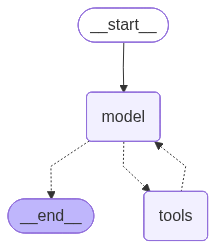

In [59]:
# ============================================================================
# 7. LangChain Agent 통합 (최신 create_agent API)
# ============================================================================

from langchain.agents import create_agent

print("\n" + "=" * 80)
print("실제 LangChain Agent 구현 (create_agent)")
print("=" * 80)

# 도구 리스트 준비
tools = [list_available_tables, query_table_data]

print(f"\n등록된 도구: {len(tools)}개")
for t in tools:
    print(f"  - {t.name}: {t.description[:50]}...")

# Agent 시스템 프롬프트
agent_system_prompt = """당신은 테이블 데이터 분석 전문 AI 어시스턴트입니다.

사용자의 질문에 답하기 위해 다음 도구를 활용할 수 있습니다:

1. list_available_tables: 사용 가능한 테이블 목록 조회
2. query_table_data: 특정 테이블의 데이터를 자연어 쿼리로 조회

**중요 지침:**
- RAG 컨텍스트에 테이블 ID가 명시되어 있으면 해당 테이블을 우선적으로 조회하세요
- 테이블을 조회하기 전에 사용자가 무엇을 원하는지 정확히 파악하세요
- 조회 결과를 바탕으로 자연스럽고 상세한 답변을 제공하세요
- 필요하다면 여러 테이블을 순차적으로 조회할 수 있습니다
"""

# Agent 생성 (최신 create_agent API)
agent = create_agent(model=llm, tools=tools, system_prompt=agent_system_prompt)
agent


In [ ]:
# ============================================================================
# 테스트 1: RAG Context 기반 질의
# ============================================================================

print("\n\n" + "=" * 80)
print("테스트 1: RAG Context 기반 질의")
print("=" * 80)

# RAG 컨텍스트
rag_context = """
검색된 문서:

1. 해외 주요 뉴스 (출처: 20251110_market_823764000.pdf, 페이지 1)
   - 섹션: 2025.11.10
   - 컬럼: 해외 주요 뉴스, 해외 주요 뉴스.1, 해외 주요 뉴스.2...
   - 테이블 ID: 6 (상세 데이터 조회 가능)

   관련 내용: 이란의 대륙간 탄도 미사일 개발 주장, 미국-이스라엘의 가자지구 재건 계획 논란 등

2. 국내 방산 업종 주요 지표 (출처: 20251110_market_823764000.pdf, 페이지 1)
   - 섹션: 2025.11.10
   - 방산 5사 시가총액, 수익률, 계약 정보 포함
   - 테이블 ID: 7 (상세 데이터 조회 가능)
"""

# 사용자 질문
user_query_1 = f"""
다음은 검색된 문서 컨텍스트입니다:
{rag_context}

질문: 이란 관련 해외 뉴스를 자세히 알려줘. 테이블 ID 6을 조회해서 상세 정보를 가져와줘.
"""

print("\n사용자 입력:")
print(user_query_1)

print("\nAgent 실행 중...")
print("-" * 80)

# 최신 API: messages 형식으로 ainvoke (async 도구 지원)
result_1 = await agent.ainvoke({"messages": [{"role": "user", "content": user_query_1}]})

print("\n" + "=" * 80)
print("Agent 최종 응답:")
print("=" * 80)
# result_1은 dict이고, messages 키에 메시지 리스트가 있음
if "messages" in result_1:
    final_message = result_1["messages"][-1]
    if hasattr(final_message, "content"):
        print(final_message.content)
    else:
        print(final_message)
else:
    print(result_1)




테스트 1: RAG Context 기반 질의

📝 사용자 입력:

다음은 검색된 문서 컨텍스트입니다:

검색된 문서:

1. 해외 주요 뉴스 (출처: 20251110_market_823764000.pdf, 페이지 1)
   - 섹션: 2025.11.10
   - 컬럼: 해외 주요 뉴스, 해외 주요 뉴스.1, 해외 주요 뉴스.2...
   - 테이블 ID: 6 (상세 데이터 조회 가능)

   관련 내용: 이란의 대륙간 탄도 미사일 개발 주장, 미국-이스라엘의 가자지구 재건 계획 논란 등

2. 국내 방산 업종 주요 지표 (출처: 20251110_market_823764000.pdf, 페이지 1)
   - 섹션: 2025.11.10
   - 방산 5사 시가총액, 수익률, 계약 정보 포함
   - 테이블 ID: 7 (상세 데이터 조회 가능)


질문: 이란 관련 해외 뉴스를 자세히 알려줘. 테이블 ID 6을 조회해서 상세 정보를 가져와줘.


🤖 Agent 실행 중...
--------------------------------------------------------------------------------

🔄 테이블 6 (해외 주요 뉴스) 쿼리 처리 중...
   쿼리: 이란 관련 해외 뉴스 상세 내용

🔄 테이블 6 (해외 주요 뉴스) 쿼리 처리 중...
   쿼리: 이란 관련 뉴스를 포함한 해외 주요 뉴스

🔄 테이블 6 (해외 주요 뉴스) 쿼리 처리 중...
   쿼리: 첫 20개 행 조회
   생성된 코드: result = df.head(20)
   ✅ 실행 성공

📤 Agent 최종 응답:
테이블 ID 6의 해외 주요 뉴스 중 이란 관련 상세 내용은 다음과 같습니다:

- 이란은 미국에 도달할 수 있는 사거리 10,000km의 새로운 대륙간 탄도 미사일을 개발했다고 주장했습니다.
- 이란 국영 방송은 해당 미사일이 "거의 실전 배치 준비 완료" 상태라고 보도했으며, 최대 1만km 떨어진 목표물 타격이 가능하다고 주장하고 있습니다. 이론적으로는

In [61]:
# ============================================================================
# 테스트 2: 복합 질의 (여러 테이블 조회)
# ============================================================================

print("\n\n" + "=" * 80)
print("테스트 2: 여러 테이블 조회")
print("=" * 80)

user_query_2 = """
사용 가능한 모든 테이블을 확인하고, 방산 관련 테이블이 있으면
최근 계약 정보 중 상위 3개를 보여줘.
"""

print("\n사용자 입력:")
print(user_query_2)

print("\nAgent 실행 중...")
print("-" * 80)

# 최신 API: messages 형식으로 ainvoke (async 도구 지원)
result_2 = await agent.ainvoke({"messages": [{"role": "user", "content": user_query_2}]})

print("\n" + "=" * 80)
print("Agent 최종 응답:")
print("=" * 80)
if "messages" in result_2:
    final_message = result_2["messages"][-1]
    if hasattr(final_message, "content"):
        print(final_message.content)
    else:
        print(final_message)
else:
    print(result_2)




테스트 2: 여러 테이블 조회

📝 사용자 입력:

사용 가능한 모든 테이블을 확인하고, 방산 관련 테이블이 있으면
최근 계약 정보 중 상위 3개를 보여줘.


🤖 Agent 실행 중...
--------------------------------------------------------------------------------

🔄 테이블 7 (테이블 7) 쿼리 처리 중...
   쿼리: 방산 관련 최근 계약 정보 상위 3개

🔄 테이블 7 (테이블 7) 쿼리 처리 중...
   쿼리: 최근 계약 정보에서 방산 관련 내용이 포함된 상위 3개 행

🔄 테이블 7 (테이블 7) 쿼리 처리 중...
   쿼리: 최근 계약 정보에서 방산 관련 키워드가 포함된 행 조회

🔄 테이블 7 (테이블 7) 쿼리 처리 중...
   쿼리: 최근 계약 정보 조회 상위 3개
   생성된 코드: result = df.head(3)
   ✅ 실행 성공

📤 Agent 최종 응답:
사용 가능한 테이블 중에서 "테이블 7"을 기준으로 최근 계약 정보 상위 3개를 조회하였으나, 방산 관련 정보가 명확히 포함되어 있지 않고 데이터가 불완전하게 나타나 있습니다.

혹시 추가로 방산 관련 특정 키워드나 계약 정보의 구체적인 조건을 알려주시면 더 정확히 찾아보겠습니다. 아니면 다른 방면의 자료 조회도 도와드릴 수 있습니다. 필요한 내용을 말씀해 주세요.


In [ ]:
# ============================================================================
# 테스트 3: 집계 연산
# ============================================================================

print("\n\n" + "=" * 80)
print("테스트 3: 집계 연산 (데이터 분석)")
print("=" * 80)

user_query_3 = """
테이블 6 (해외 주요 뉴스)에서 총 몇 개의 뉴스가 있는지 알려줘.
"""

print("\n📝 사용자 입력:")
print(user_query_3)

print("\n🤖 Agent 실행 중...")
print("-" * 80)

# 최신 API: messages 형식으로 ainvoke (async 도구 지원)
result_3 = await agent.ainvoke({"messages": [{"role": "user", "content": user_query_3}]})

print("\n" + "=" * 80)
print("📤 Agent 최종 응답:")
print("=" * 80)
if "messages" in result_3:
    final_message = result_3["messages"][-1]
    if hasattr(final_message, "content"):
        print(final_message.content)
    else:
        print(final_message)
else:
    print(result_3)

print("\n\n" + "=" * 80)
print("✅ 모든 Agent 테스트 완료!")
print("=" * 80)
print("\n💡 요약:")
print("   - create_agent: LangChain 1.0 최신 API 사용")
print("   - ainvoke 사용: async 도구를 지원하기 위해 ainvoke 사용")
print("   - invoke 형식: {'messages': [{'role': 'user', 'content': '...'}]}")
print("   - Agent가 자동으로 도구를 선택하고 호출합니다")
print("   - RAG Context에서 테이블 ID를 인식하여 조회합니다")
